# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points


### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  



### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  **We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors.** Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


### Imports

In [450]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse   import urlparse
from itertools      import chain, combinations

# Data Science Libraries
import numpy as     np
import pandas as    pd
import seaborn as   sns

# Visualization
import matplotlib.pyplot as     plt
import matplotlib.patches as    patches
import matplotlib.ticker as     mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import       StandardScaler, OrdinalEncoder
from sklearn.impute import              SimpleImputer
from sklearn.metrics import             mean_squared_error
from sklearn.feature_selection import   SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import            make_regression
from sklearn.ensemble import            BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42
color        = sns.color_palette()

### Utility Functions

#### Formatting

In [451]:
# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


#### Null Handling

In [452]:
# This function will list how many nulls occur in which features

def show_null_counts_features(df):
    """
    Returns a DataFrame containing the count and percentage of null values for each feature in the input DataFrame.
    """

    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    # feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    feature_dtypes = df.dtypes      # Get the dtype of each column

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature':        count_nulls[count_nulls > 0].index,
        '#_Null_Values':  count_nulls[count_nulls > 0].values,
        'Null_%':         df_nulls[df_nulls > 0].values,
        'Feature_Dtype':  feature_dtypes[count_nulls > 0].values,
        # 'Feature_Type':   feature_types[count_nulls > 0].values
    }).sort_values(by = 'Null_%', ascending = False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    # else:
    #     # Print null value stats
    #     print('Feature Name    # Nulls      Null %    Type')
    #     print('------------    -------      ------    ----')
    #     for index, row in missing_data.iterrows():
    #         print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")

    return missing_data


In [453]:
def drop_na_below_threshold(df: pd.DataFrame, threshold: int):
    for column in df.columns:
        null_percentage = df[column].isna().mean() * 100 #.mean(): When applied to a boolean Series, it calculates the mean by treating True as 1 and False as 0. So, it effectively gives the proportion of missing values in the column.
        if null_percentage < threshold:
            df[column].dropna(inplace = True)
    return df

#### Data Viz

In [454]:
def create_plots(df: pd.DataFrame, feature: str, title = 'Feature', color = 'orange', bins: int = 20, log_scale = None):
    """
      Creates a histogram and boxplot for a specified feature in a DataFrame.

      Args:
          df (pd.DataFrame): The DataFrame containing the data.
          feature (str): The name of the feature to plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for feature
    sns.histplot(df[feature], bins = bins, color=color, ax=axes[0], log_scale = log_scale)
    # axes[0].set_title(f'Distribution of {title}')
    axes[0].set_xlabel(f'{title}')
    axes[0].set_ylabel('Frequency')
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Boxplot for feature
    sns.boxplot(x = df[feature], color = color, ax=axes[1], log_scale = log_scale)
    # axes[1].set_title(f'Boxplot of {title}')
    axes[1].set_xlabel(f'{title}')
    axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))


    plt.tight_layout()
    plt.show()

#### Forward / Backward Selection

In [455]:
def sequential_feature_selection(X, y, model,
                                 direction      = 'forward',  # 'forward' or 'backward'
                                 scoring        = 'neg_mean_squared_error',
                                 cv: int        = 5,
                                 tol            = None,               # None = no delta cutoff
                                                         # use 0.0 for "no further improvements"
                                                         # and 1e-4 for "point of diminishing returns"
                                 max_features   = None,      # None = use all features
                                 n_jobs: int    = -1,
                                 verbose: bool  = False
                                ):
    """
    Performs sequential feature selection (forward or backward).

    Args:
        X (pd.DataFrame or np.ndarray):     Feature matrix.
        y (pd.Series or np.ndarray):        Target vector.
        model:                              Estimator instance to use for feature selection.
        direction (str, optional):          'forward' or 'backward' selection. Defaults to 'forward'.
        scoring (str or callable, optional): Scoring metric to use. Default = 'neg_mean_squared_error'.
        cv (int):                           # of Cross-validation folds. Defaults = 5.
        tol (float, optional):              Tolerance for stopping the selection. If the improvement in score is less than tol, the selection stops. Defaults to None.
        max_features (int, optional):       Max number of features to select. Default = None (all features).
        n_jobs (int, optional):             Number of jobs to run in parallel. Defaults = -1.
        verbose (bool, optional):           For printing progress updates. Defaults = False.

    Returns:
        tuple:
            - selected_features (list):     List of selected feature names.
            - best_scores (list):           List of cross-validation scores at each step of selection.
            - best_feature_set (list):      Subset of features that achieved the best CV score.
            - best_score (float):           best CV score achieved.
    """

    if max_features is None:
        max_features = X.shape[1]
    else:
        max_features = max_features

    sfs = SequentialFeatureSelector(
        estimator             = model,
        n_features_to_select  = max_features,
        direction             = direction,
        scoring               = scoring,
        cv                    = cv,
        n_jobs                = n_jobs
    )

    sfs.fit(X, y)

    selected_features_mask  = sfs.get_support()
    selected_features       = list(X.columns[selected_features_mask])

    # Re-calculate scores to track the improvement at each step
    best_scores         = []
    current_features    = []
    best_feature_set    = None
    best_score          = float('inf') if scoring.startswith('neg') else float('-inf')
    previous_score      = float('inf') if scoring.startswith('neg') else float('-inf')
    greater_is_better   = not scoring.startswith('neg')

######### FORWARD SELECTION #############
    if direction == 'forward':
        all_features = list(X.columns)
        for feature_index in np.where(selected_features_mask)[0]:
            feature_name = all_features[feature_index]
            current_features.append(feature_name)
            cv_score = cross_val_score(model, X[current_features], y, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            best_scores.append(cv_score)

            if verbose:
                print(f"\nFeatures: {current_features[-3:]}, CV Score ({scoring}): {cv_score:.4f}")

            # Update best score and feature set
            if (greater_is_better and cv_score > best_score) or (not greater_is_better and cv_score < best_score):
                best_score = cv_score
                best_feature_set = current_features.copy()

            # Check for early stopping based on tolerance
            improvement = cv_score - previous_score if greater_is_better else previous_score - cv_score
            if tol is not None and improvement < tol:
                if verbose:
                    print("Stopping early due to minimal improvement.")
                break
            previous_score = cv_score

######### BACKWARD SELECTION #############

    elif direction == 'backward':
        all_features      = list(X.columns)
        initial_features  = list(X.columns)
        remaining_mask    = np.ones(len(initial_features), dtype=bool)
        num_to_remove     = len(initial_features) - len(selected_features)

        for _ in range(num_to_remove):
            # Identify feature to remove at this step
            current_features_at_step = list(np.array(initial_features)[remaining_mask])
            scores = {}
            for i, feature_name in enumerate(current_features_at_step):
                temp_mask                                   = remaining_mask.copy()
                temp_mask[all_features.index(feature_name)] = False

                cv_score              = cross_val_score(model, X.loc[:, temp_mask], y, scoring = scoring, cv = cv, n_jobs = n_jobs).mean()
                scores[feature_name]  = cv_score

            feature_to_remove = min(scores, key = scores.get) if not greater_is_better else max(scores, key = scores.get)
            remaining_mask[all_features.index(feature_to_remove)] = False
            current_score = scores[feature_to_remove]
            best_scores.append(current_score)
            current_features = list(np.array(initial_features)[remaining_mask])

            if verbose:
                print(f"\nFeatures: {current_features[-3:]}, CV Score ({scoring}): {current_score:.4f}")

            # Update best score and feature set
            if (greater_is_better and current_score > best_score) or (not greater_is_better and current_score < best_score):
                best_score = current_score
                best_feature_set = current_features.copy()

            # Check for early stopping based on tolerance
            improvement = current_score - previous_score if greater_is_better else previous_score - current_score
            if tol is not None and improvement < tol:
                if verbose:
                    print("Stopping early due to minimal improvement.")
                break
            previous_score = current_score

    return (
        selected_features,
        best_scores,
        best_feature_set,
        best_score
    )

#### Misc.

In [527]:
# Forward Feature Selection

def forward_feature_selection(X, y, model,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            scores[feature] = np.sqrt(cv_score)

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

In [457]:
# # Backward selection
# sfs_backward = SequentialFeatureSelector(model, direction='backward')
# sfs_backward.fit(X_numeric, y)
# print("Backward selection features:", X_numeric.columns[sfs_backward.get_support()].tolist())

In [458]:
# # Backward Feature Selection

# def backward_feature_selection(X, y, model,
#                                scoring='neg_mean_squared_error',
#                                cv=5,
#                                tol=None,               # None = no delta cutoff
#                                                        # use 0.0 for "no further improvements"
#                                                        # and 1e-4 for "point of diminishing returns"
#                                max_features=None,      # If None, remove features until only 1 remains
#                                                        # Otherwise, stop when this many features remain
#                                n_jobs=-1,
#                                verbose=False
#                               ):

#     # Helper function to compute CV score using LinearRegression
#     def cv_score(features):
#         return -cross_val_score(model, X[features], y,
#                                 scoring=scoring, cv=cv,
#                                 n_jobs=n_jobs          ).mean()

#     # Start with all features (using a list for easier manipulation)
#     features_remaining = list(X.columns)

#     # Compute initial CV score with the full feature set
#     initial_score = np.sqrt(cv_score(features_remaining))

#     # Initialize tracking variables
#     best_score        = initial_score                # Best (lowest) CV score observed so far
#     best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
#     selected_features = ['NONE']                     # List to record the order in which features are removed
#     best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)

#     if verbose:
#         print("Start with full set of features:")
#         print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')

#     # Determine the target number of features to keep:
#     # For backward elimination, if max_features is None, we remove until 1 feature remains.
#     target_feature_count = 1 if max_features is None else max_features

#     prev_score = initial_score
#     round_num = 1
#     # Continue removing features until we reach the target count
#     while len(features_remaining) > target_feature_count:
#         if verbose:
#             print(f'Round {round_num}:')

#         # Initialize variables to track the best removal in this round
#         lowest_score = float('inf')
#         feature_to_remove = None
#         best_new_features = None

#         # Try removing each feature one at a time
#         for feature in features_remaining:
#             new_feature_set = features_remaining.copy()
#             new_feature_set.remove(feature)
#             new_score = cv_score(new_feature_set)
#             if verbose:
#                 print('Trying removal of:',feature, np.around(new_score, 4))
#             if new_score < lowest_score:
#                 lowest_score = new_score
#                 feature_to_remove = feature
#                 best_new_features = new_feature_set

#         # Check if improvement is significant enough (if tol is set)
#         if tol is not None and (prev_score - lowest_score) < tol:
#             if verbose:
#                 print("\nStopping early due to minimal improvement.")
#             break

#         # Update the best score and feature set if current removal improves performance
#         if lowest_score < best_score:
#             best_score = lowest_score
#             best_feature_set = best_new_features.copy()

#         # Update trackers for this round
#         prev_score = lowest_score
#         features_remaining = best_new_features
#         selected_features.append(feature_to_remove)
#         best_scores.append(lowest_score)

#         if verbose:
#             print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
#         round_num += 1

#     return (
#         selected_features,      # Order in which features were removed
#         best_scores,            # CV scores after each removal step
#         best_feature_set,       # Feature set that achieved the best CV score
#         best_score              # Best (lowest) CV score
#     )

## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [459]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  


#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)

##### <font color='limegreen'>**1.1.</font>**  What is the objective of this project in business terms?


<font color='magenta'> Objective:  To develop a model that accurately predicts the <b>Assessed Tax Value</b> of a property, represented by the target variable `taxvaluedollarcnt`: Total assessed value of the property (land plus structure) in dollars.   This value, in turn, is used to determine a homeowner's annual property tax obligation. <br><br>



 <font color='magenta'>For reference, the assessed tax value is:
* <font color='magenta'>Determined by local tax assessors and assigned by a local government for property tax purposes

* <font color='magenta'> based on many factors, including location, physical characteristics, local economic conditions, recent bid/ask spreads, sales comps, replacement costs, etc.

* <font color='magenta'> Barring certain exemptions (i.e., a calamity), the value is subject to regular upward revision.

* <font color='magenta'> an unofficial floor value of a property. It's generally never larger than Fair Market Value (exceptions can arise, but they are subject to appeal with local tax assessors).

> Assessed tax value = Property tax bill x (100 / County Tax rate)
</font>



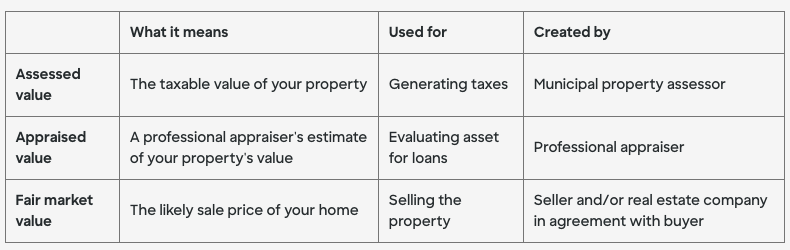

##### **<font color='limegreen'>1.2.</font>**  How will your solution be used?

<font color='magenta'>
A model that more accurately predicts the assessed tax value of properties can enhance the accuracy of Zillow's property valuations, which are estimates of Fair Market Value (FMV).<br><br>These home valuation estimates (or 'Zestimates') are an important price discovery mechanism for on- and off-market residential properties in the U.S.A.; they inform the decisions of buyers, sellers, investors, insurers, lenders, etc.,  as well as support the development of other products and services that rely on property data.
<br><br>Also, Zillow has competitors like RedFin. Improvements in Zillow's prediction accuracy represent a competitve advantage.

</font>

##### **1.3:**  How should success (or failure) be measured?


<font color='magenta'> Sucess will be measured by the accuracy and reliability of the model's predictions vs. the actual assessed tax values.

<font color='magenta'>
Key metrics for evaluation include:

* <font color='magenta'>Mean Absolute Error (MAE)

* <font color='magenta'>Root Mean Squared Error (RMSE)

* <font color='magenta'>R-squared

High prediction errors and over/underfitting will be an indication of failure.
</font>

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### <font color='limegreen'>2.A.</font> Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [460]:
df = df.round(4)
df.head(10)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0
5,17143294,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1982.0,2.0,NaN,2016.0,NaN,NaN,6.111005e+13,331064.0
6,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,NaN,...,NaN,NaN,1950.0,NaN,NaN,2016.0,NaN,NaN,6.037461e+13,773303.0
7,12069064,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,NaN,...,NaN,NaN,1922.0,NaN,NaN,2016.0,NaN,NaN,6.037302e+13,218552.0
8,12790562,NaN,NaN,NaN,3.0,4.0,NaN,9.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037500e+13,220583.0
9,11542646,NaN,NaN,NaN,3.0,2.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1980.0,NaN,NaN,2016.0,NaN,NaN,6.037275e+13,371361.0


###### .info & .describe

In [461]:
print(f'Shape: {df.shape}\n')
df.info()

Shape: (77613, 55)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-

In [462]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


###### Null Counts

In [463]:
# property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)


In [464]:
print("------------------ % Not Null ---------------------- ")
df.notnull().mean().sort_values(ascending = False)


------------------ % Not Null ---------------------- 


,0
parcelid,1.000000
bedroomcnt,0.999562
bathroomcnt,0.999562
fips,0.999562
propertylandusetypeid,0.999562
longitude,0.999562
latitude,0.999562
roomcnt,0.999562
assessmentyear,0.999562
regionidcounty,0.999562


In [465]:
null_counts_df = show_null_counts_features(df)
null_counts_df

The dataset contains 77613 samples.



,Feature,#_Null_Values,Null_%,Feature_Dtype
5,buildingclasstypeid,77598,99.98,float64
12,finishedsquarefeet13,77571,99.95,float64
2,basementsqft,77563,99.94,float64
40,storytypeid,77563,99.94,float64
45,yardbuildingsqft26,77543,99.91,float64
48,fireplaceflag,77441,99.78,object
1,architecturalstyletypeid,77406,99.73,float64
42,typeconstructiontypeid,77390,99.71,float64
15,finishedsquarefeet6,77227,99.50,float64
28,pooltypeid10,77148,99.40,float64


###### Duplicates - dropping duplicate rows (based on `parcelid`) before any further analysis

In [466]:
## Duplicates ##

duplicates = df.duplicated()
print(f'{duplicates.sum()} duplicates \n{(~duplicates).sum()} unique')

dups_df = df[duplicates]
dups_df

199 duplicates 
77414 unique


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
117,11393337,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,1940.0,NaN,NaN,2016.0,Y,14.0,6.037235e+13,43439.0
625,14634203,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1974.0,1.0,NaN,2016.0,NaN,NaN,6.059001e+13,289445.0
1018,11721753,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1923.0,NaN,NaN,2016.0,NaN,NaN,6.037220e+13,205123.0
1248,11289917,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,Y,15.0,6.037901e+13,136104.0
1734,11637029,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,NaN,...,NaN,NaN,1980.0,NaN,NaN,2016.0,Y,13.0,6.037701e+13,810694.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60010,13066981,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,...,NaN,NaN,1983.0,NaN,NaN,2016.0,NaN,NaN,6.037403e+13,366160.0
62239,10852812,NaN,NaN,NaN,7.0,11.0,NaN,8.0,7.0,NaN,...,NaN,NaN,1949.0,NaN,NaN,2016.0,NaN,NaN,NaN,5373376.0
63132,12136147,NaN,NaN,NaN,2.0,3.0,NaN,5.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2016.0,NaN,NaN,6.037431e+13,775383.0
64278,17282392,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,1054.0,NaN,1963.0,1.0,NaN,2016.0,NaN,NaN,6.111007e+13,498684.0


In [467]:
#### DROP DUPLICATE ROWS (Based on `parcelid`)

df = df.drop_duplicates(subset='parcelid', keep='first')
df.shape

(77414, 55)

######Unique Values

In [468]:
print("Unique Values")
df.nunique().sort_values(ascending=False)

Unique Values


,0
parcelid,77414
latitude,64038
longitude,62461
taxvaluedollarcnt,50949
censustractandblock,39006
lotsizesquarefeet,18848
rawcensustractandblock,8268
calculatedfinishedsquarefeet,4972
finishedsquarefeet12,4868
propertyzoningdesc,1907


#### **2.A Discussion**
Answer the following questions.



##### <font color='limegreen'>**2.A.1.**</font>  Which features are categorical?

In [469]:
# feature_types         = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
# categorical_features  = feature_types[feature_types == 'Categorical'].index.tolist()

In [470]:
categorical_col_names = [
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingclasstypeid',
    'buildingqualitytypeid',
    'censustractandblock',
    'decktypeid',
    'fips',
    'fireplaceflag',
    'hashottuborspa',
    'heatingorsystemtypeid',
    'parcelid',
    'poolcnt', #arguably numeric in theory, but limmited to either 1 or 0
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'propertycountylandusecode',
    'propertylandusetypeid',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'storytypeid',
    'typeconstructiontypeid',
    'taxdelinquencyflag',
]

print(f'Number of categorical variables: {len(categorical_col_names)}')

Number of categorical variables: 22


<font color='magenta'> -------------------------------CATEGORICAL VARIABLES -------------------------------------------- </font>

  - `airconditioningtypeid`: `(e.g., central AC, window unit, none)`

  - `architecturalstyletypeid`: (e.g., Ranch, Victorian, Contemporary)

  - `buildingclasstypeid`: (e.g., classifications of building types)

  - `buildingqualitytypeid` <br> *Numeric value indicating the quality of the building (higher values often indicate better quality)*

  - `censustractandblock`: <br> *a combined location identifier, quite specific but maybe not so specific as to be a unique identifier*

  - `decktypeid`:<br> *Either blank or '66', whatever that means... probably keep this feature and encode as binary*

  - `fips`<br>
 *County codes... these might be unique identifiers and therefore droppable*

  - `hashottuborspa` <br>
    *Boolean. Seems to contain exact same info as pooltypeid10, so the latter can be dropped*

  - `heatingorsystemtypeid`: (e.g., forced air, electric)

  - `poolcnt` <br>
    *The label is misleading because this is really a binary indicator. Max value = 1, and the remaining are blank. Therefore we'll encode 1 to indicate that the property has a pool, 0 for no pool.*

  - `pooltypeid10`, `pooltypeid2`, `pooltypeid7`<br>*Flags or codes indicating pool types - to be dropped*

  - `propertycountylandusecode`: (Codes for land use categories)

  - `propertylandusetypeid`: (IDs representing land use types)

  - `propertyzoningdesc`: (Text descriptions of zoning)

  - `rawcensustractandblock`<br> *repeat of censustrackandblock... one of these shoudl be dropped*

  - `storytypeid`: (e.g., one-story, two-story)

  - `typeconstructiontypeid`: (e.g., wood frame, concrete)

  - `taxdelinquencyflag`:<br>  *Yes/No, encode as 1/0*

  - `fireplaceflag`:<br>
   *(e.g., True, False). This feature will need to be reconciled with the `fireplacecnt` feature and encoded as 1 for True and 0 for False.*

<font color='magenta'>-----------------------------------------------------------------------------------------</font>

###### Categorical Data

In [471]:
categorical_df = df[categorical_col_names]
categorical_df.head(30)

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,buildingqualitytypeid,censustractandblock,decktypeid,fips,fireplaceflag,hashottuborspa,heatingorsystemtypeid,...,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,storytypeid,typeconstructiontypeid,taxdelinquencyflag
0,NaN,NaN,NaN,NaN,6.059063e+13,NaN,6059.0,NaN,NaN,NaN,...,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,6.111001e+13,NaN,6111.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,6.059022e+13,NaN,6059.0,NaN,NaN,NaN,...,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,NaN,NaN,NaN
3,NaN,NaN,NaN,8.0,6.037300e+13,NaN,6037.0,NaN,NaN,2.0,...,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,NaN,NaN,NaN
4,1.0,NaN,NaN,8.0,6.037124e+13,NaN,6037.0,NaN,NaN,2.0,...,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,6.111005e+13,NaN,6111.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1129,266.0,NaN,6.111005e+07,NaN,NaN,NaN
6,1.0,NaN,NaN,9.0,6.037461e+13,NaN,6037.0,NaN,NaN,2.0,...,NaN,NaN,1.0,0101,261.0,PSR2,6.037461e+07,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,6.037302e+13,NaN,6037.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0100,261.0,GLR4YY,6.037302e+07,NaN,NaN,NaN
8,NaN,NaN,NaN,9.0,6.037500e+13,NaN,6037.0,NaN,NaN,2.0,...,NaN,NaN,NaN,0100,261.0,WHRE20000*,6.037500e+07,NaN,NaN,NaN
9,NaN,NaN,NaN,8.0,6.037275e+13,NaN,6037.0,NaN,NaN,2.0,...,NaN,NaN,1.0,010C,266.0,LAR3,6.037275e+07,NaN,NaN,NaN


###### Numeric Data

In [472]:
numeric_df = df.drop(categorical_col_names, axis=1)
numeric_df

,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,...,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,assessmentyear,taxdelinquencyyear,taxvaluedollarcnt
0,NaN,3.5,4.0,3.5,NaN,3100.0,3100.0,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,1998.0,NaN,2016.0,NaN,1023282.0
1,NaN,1.0,2.0,1.0,1465.0,1465.0,1465.0,NaN,NaN,1465.0,...,5.0,NaN,NaN,NaN,NaN,1967.0,1.0,2016.0,NaN,464000.0
2,NaN,2.0,3.0,2.0,NaN,1243.0,1243.0,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,1962.0,1.0,2016.0,NaN,564778.0
3,NaN,3.0,4.0,3.0,NaN,2376.0,2376.0,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,1970.0,NaN,2016.0,NaN,145143.0
4,NaN,3.0,3.0,3.0,NaN,1312.0,1312.0,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,1964.0,NaN,2016.0,NaN,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,NaN,3.0,3.0,3.0,NaN,1741.0,1741.0,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,1980.0,NaN,2016.0,NaN,379000.0
77609,NaN,2.0,2.0,2.0,NaN,1286.0,1286.0,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,1940.0,NaN,2016.0,NaN,354621.0
77610,NaN,2.0,4.0,2.0,1612.0,1612.0,1612.0,NaN,NaN,1612.0,...,7.0,NaN,NaN,656.0,NaN,1964.0,1.0,2016.0,NaN,67205.0
77611,NaN,1.0,3.0,1.0,NaN,1032.0,1032.0,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,1954.0,NaN,2016.0,NaN,49546.0


##### **<font color='limegreen'>2.A.2</font>**  Are there any features which appear at first glance to be **useless** for the **business purpose** of this project and should be deleted?  Give examples and describe your reasoning briefly.


- `parcelid`<br> *unique identifier, not helpful*

- `decktypeid`<br>*614 values with value '66', unhelpful.*

- `finishedsquarefeet12`, `finishedsquarefeet13`, `finishedsquarefeet15`, `finishedsquarefeet50`, `finishedsquarefeet6`

- `rawcensustractandblock`<br>*Redundant. Less processed version of `censustractandblock`*

- `storytypeid`<br>*Numerical ID that describes all types of homes. Mostly missing, so we should drop this category.*

- `unitcnt`<br>*If project only focuses on  single-family homes and this column has a consistent value (like 1) for most entries, the feature can be excluded. If column also reflects multi-unit proerties, then include feature.*

- `pooltypeid10`,`pooltypeid2`, `pooltypeid7`
  <br>*We only care whether the property has a pool or not*

- `yardbuildingsqft17`,
- `yardbuildingsqft26`: Similar to deck type, unless the business purpose specifically involves analyzing yard buildings, these specific square footage measurements might not be broadly useful.

- `assessmentyear`<br> *All samples have the same value of 2016, zero variance feature, to be excluded.*

</span>

##### **<font color='limegreen'>2.A.3.</font>**  Are there any features which appear to be **useless** because of the percentage of **missing values**?  If so, give an example.

In [473]:
null_counts_df['Is_Categorical'] = null_counts_df['Feature'].apply(lambda x: x in categorical_col_names)
print(f'Length: {null_counts_df.shape[0]}')
null_counts_df


Length: 54


,Feature,#_Null_Values,Null_%,Feature_Dtype,Is_Categorical
5,buildingclasstypeid,77598,99.98,float64,True
12,finishedsquarefeet13,77571,99.95,float64,False
2,basementsqft,77563,99.94,float64,False
40,storytypeid,77563,99.94,float64,True
45,yardbuildingsqft26,77543,99.91,float64,False
48,fireplaceflag,77441,99.78,object,True
1,architecturalstyletypeid,77406,99.73,float64,True
42,typeconstructiontypeid,77390,99.71,float64,True
15,finishedsquarefeet6,77227,99.50,float64,False
28,pooltypeid10,77148,99.40,float64,True


<span style="color:magenta">

- `architecturalstyletypeid` <br> *99.7% missing, only 207 non-null values out of 77,613.*

- `basementsqft` <br> *99.9% missing - with such a low fill rate, useless*

- `buildingclasstypeid`<br>*99.98% missing, 15 non-null values.*

- `decktypeid`<br>*99.2% missing, 614 non-null values.*

- `finishedfloor1squarefeet` (92.2% missing): Only 6,037 non-null values.

- `finishedsquarefeet13` (99.95% missing): Only 42 non-null values.

- `finishedsquarefeet15` (96.1% missing): Only 3,027 non-null values. Similar to `finishedfloor1squarefeet`, potentially useful.

- `finishedsquarefeet6` (99.5% missing): Only 386 non-null values.

- `poolsizesum` (98.9% missing): Only 869 non-null values. If the presence of a pool (poolcnt) is important, this specific size might be too sparsely populated.

- `pooltypeid10` (99.4% missing): Only 465 non-null values. Specific pool type with very low occurrence.

- `storytypeid` (99.9% missing): Only 50 non-null values. Similar to basementsqft, might be geographically specific but too sparse.

- `typeconstructiontypeid` (99.7% missing): Only 223 non-null values. Construction type could be valuable, but the missing rate is extremely high.

- `yardbuildingsqft17` (96.9% missing):  2,393 non-null values.

- `yardbuildingsqft26` (99.9% missing): 70 non-null values.

- `fireplaceflag` (99.8% missing): Maybe better to encode NaN as 0....

</span>

##### <font color = 'limegreen'>**2.A.4.</font>**  Are there any features which appear to be **useless** because of the number of **unique values**?  If so, give an example.

In [474]:
df.nunique().sort_values(ascending=False)

,0
parcelid,77414
latitude,64038
longitude,62461
taxvaluedollarcnt,50949
censustractandblock,39006
lotsizesquarefeet,18848
rawcensustractandblock,8268
calculatedfinishedsquarefeet,4972
finishedsquarefeet12,4868
propertyzoningdesc,1907


<font color='magenta'>Answering this depends on a few factors:-----------------------------------------


1. First, for certain features, NaN is equivalent to False or 0, so those features need to be updated. Example: `taxdelinquencyflag` or `poolcnt`.

2. Once #1 is resolved, we need to distinguish between a. Too *many* unique values and b. Too *few* unique values.

 Too many suggests a unique identifier, which lacks predictive power. Examples: <br>
 * `parcelid` -- unique identifier, not a useful predictor

 * `latitude` & `longitude` -- equivalent to a unique identifier. A transformed feature that grouped by ranges of latitude and longitude would be a better substitute, but there are other location features that accomplish this.

  Too few suggests either a constant (zero variance) feature, too much missing data, or a feature that simply contains no predictive power. Examples: <br>
  * `assessmentyear` - only 2016
  * `taxdelinquencyyear` - only relevant when `taxdelinquencyflag` = Yes/True/1 (~3% of values)
  * `basementsqft` - only 43 unique values. A better feature would be a flag for hasbasement
  

------------------------------------------------------------------------------------------------------------- </font>

### 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  



#### Histogram

To get an overview, generate histograms for all features using df.hist() (Hint: increase the figsize and set the layout to (-1,m) to get m columns and as many rows as necessary.)

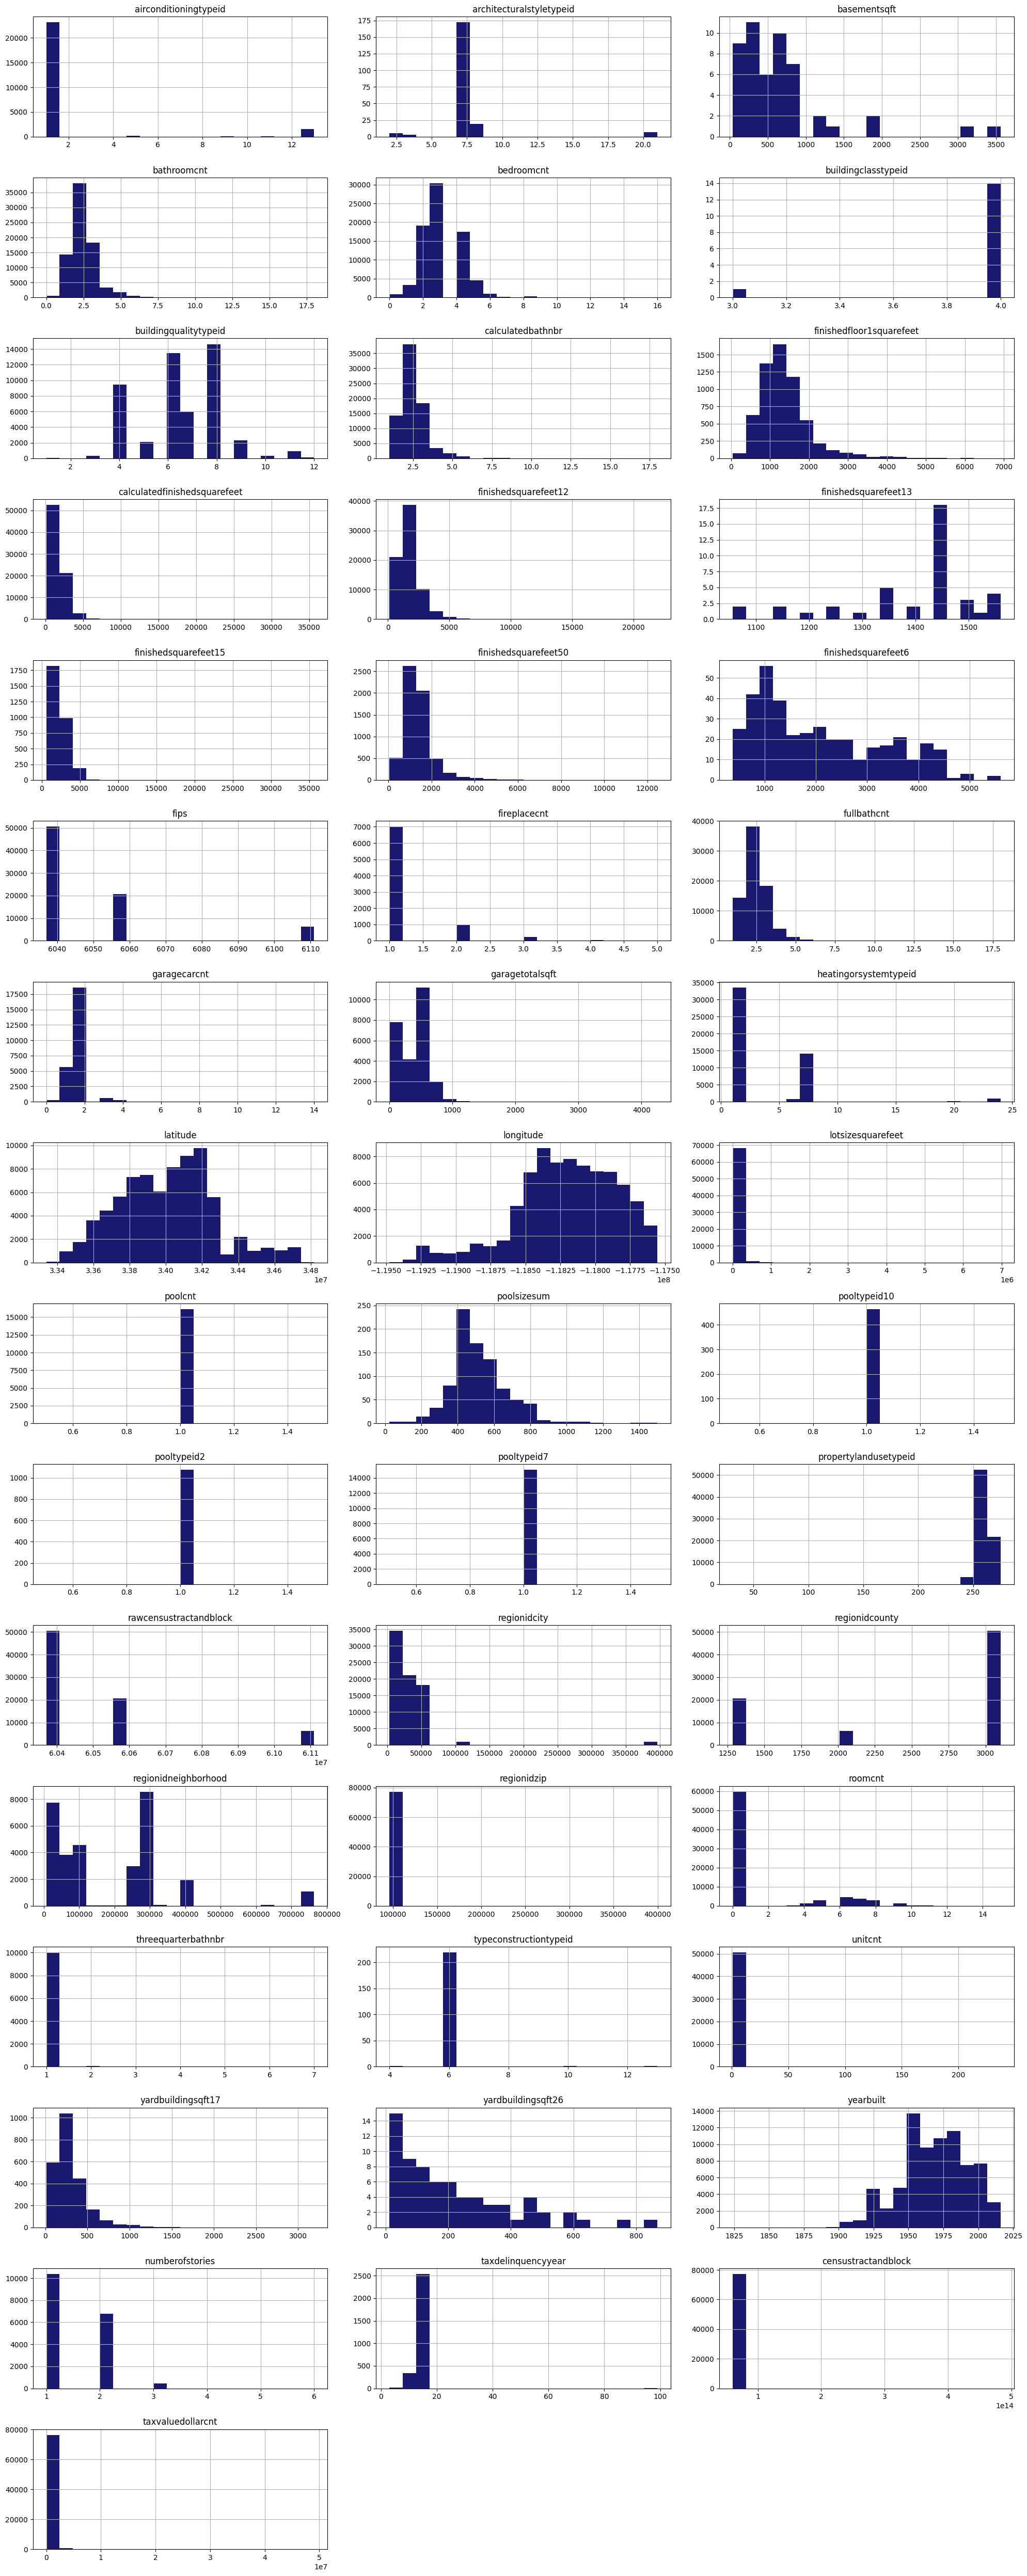

In [475]:
df.drop(columns=['assessmentyear','storytypeid','decktypeid','parcelid']).hist(figsize=(20, 50), layout=(-1, 3), color='midnightblue', bins = 20)
# plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()


#### Feature/Target Viz

Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  

  - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
  - Use as many code cells as you need, and give comments describing what each cell does.
  - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

In [476]:
features_eda = ['bathroomcnt', 'calculatedbathnbr', 'bedroomcnt', 'calculatedfinishedsquarefeet','taxvaluedollarcnt']
df_eda = df[features_eda]

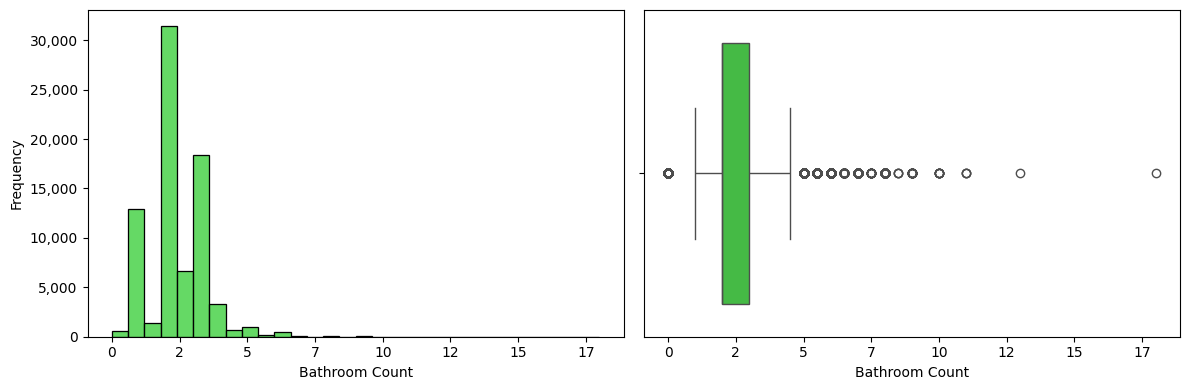

In [477]:
create_plots(df_eda, features_eda[0], 'Bathroom Count', color = 'limegreen', bins = 30)

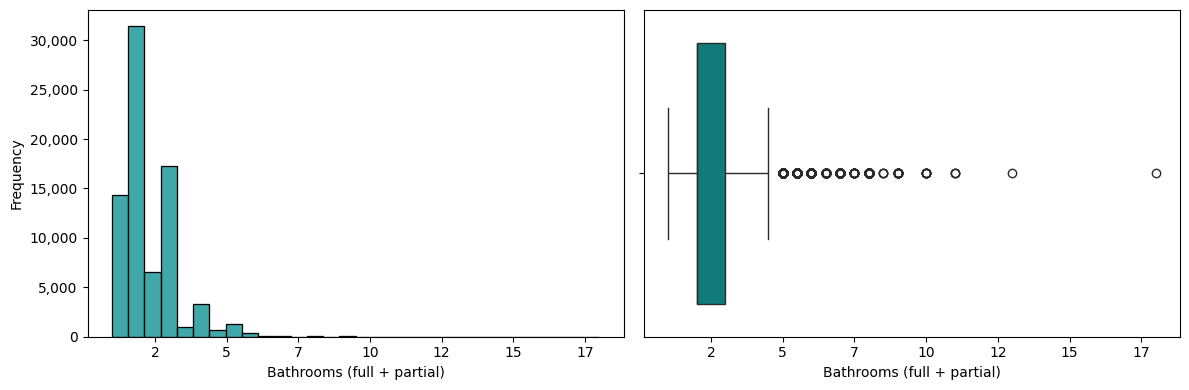

In [478]:
create_plots(df_eda, features_eda[1], 'Bathrooms (full + partial)', color = 'darkcyan', bins = 30)

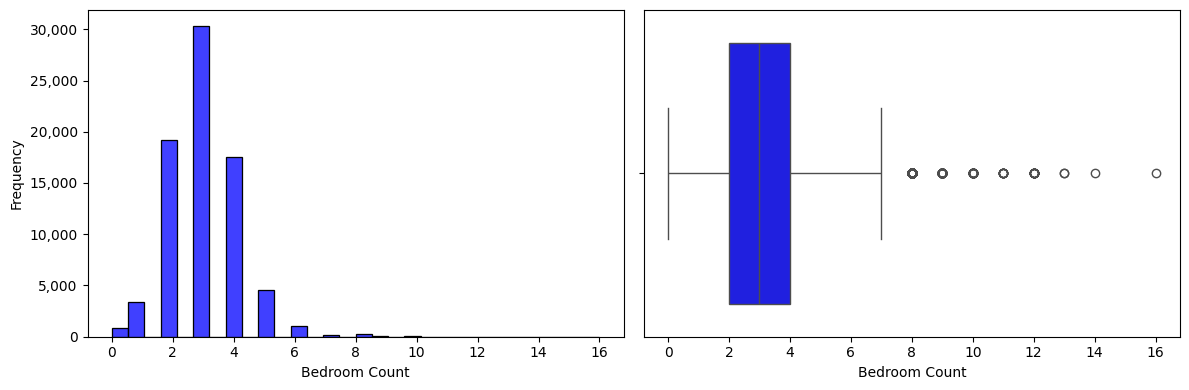

In [479]:
create_plots(df_eda, features_eda[2], 'Bedroom Count', color = 'blue', bins = 30)

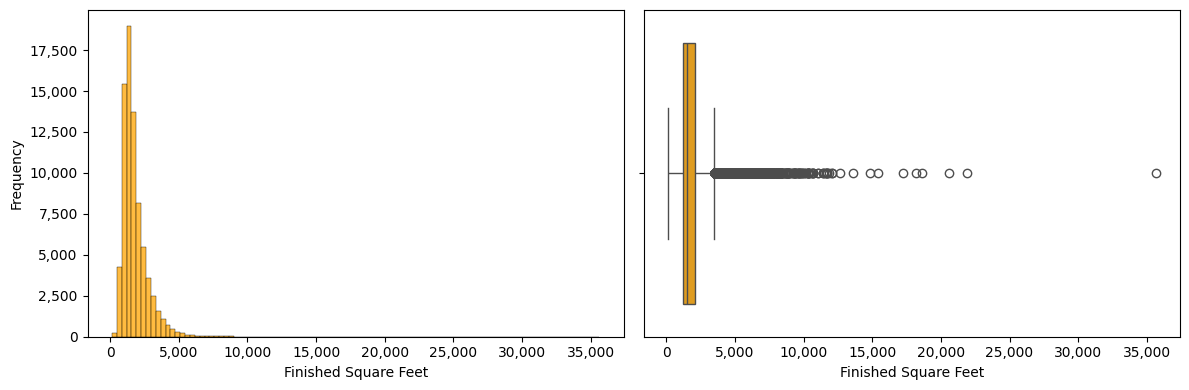

In [480]:
create_plots(df_eda, features_eda[3], 'Finished Square Feet', color = 'orange', bins = 100)

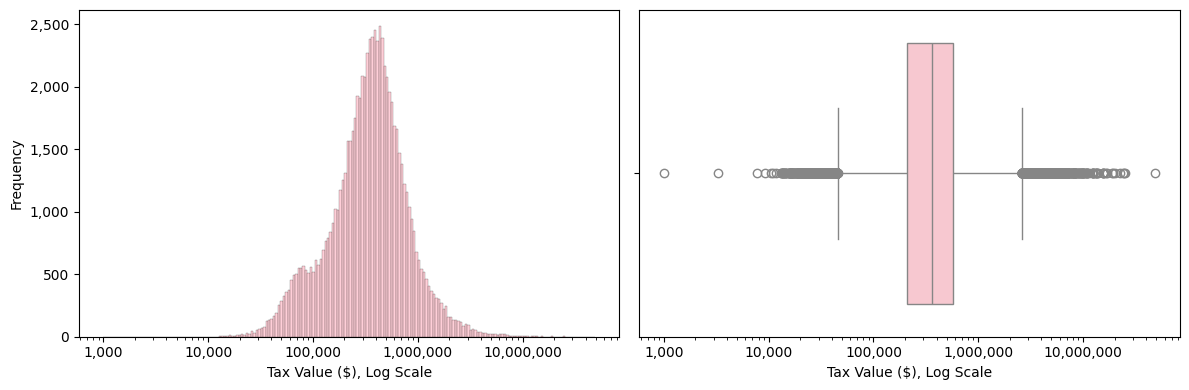

In [481]:
create_plots(df_eda, features_eda[4], 'Tax Value ($), Log Scale', color = 'pink', bins = 200, log_scale = (True, False))

##### Some location analysis, `regionidzip`

In [482]:
  #### Group by `regionidzip`, value count
df_zip = df.groupby('regionidzip')['regionidzip'].count().reset_index(name='count')
df_zip = df_zip.sort_values(by='count', ascending=False)
df_zip


,regionidzip,count
380,97319.0,825
311,96987.0,753
379,97318.0,708
374,97118.0,613
301,96974.0,593
...,...,...
185,96329.0,2
360,97092.0,1
371,97111.0,1
357,97088.0,1


In [483]:
#######  zip codes (`regionidzip`) on US Military Bases in California and Oregon ###########

zip_codes_military = [
    96201, 96202, 96203, 96204, 96205, 96206, 96207, 96208, 96209, 96210,
    96212, 96213, 96214, 96218, 96224, 96251, 96257, 96258, 96260, 96262,
    96264, 96266, 96267, 96269, 96271, 96273, 96275, 96276, 96278, 96283,
    96284, 96297, 96301, 96303, 96306, 96309, 96310, 96311, 96315, 96319,
    96321, 96322, 96323, 96326, 96328, 96330, 96331, 96336, 96337, 96338,
    96339, 96343, 96346, 96347, 96349, 96350, 96351, 96362, 96365, 96367,
    96368, 96370, 96371, 96372, 96373, 96374, 96375, 96376, 96377, 96378,
    96379, 96380, 96382, 96384, 96385, 96386, 96387, 96388, 96389, 96401,
    96502, 96504, 96505, 96507, 96510, 96511, 96515, 96516, 96517, 96520,
    96521, 96522, 96530, 96531, 96532, 96534, 96535, 96537, 96539, 96540,
    96542, 96543, 96546, 96548, 96549, 96550, 96551, 96552, 96553, 96554,
    96555, 96557, 96562, 96577, 96578, 96595, 96598, 96599, 96601, 96602,
    96603, 96604, 96605, 96606, 96607, 96608, 96609, 96610, 96611, 96612,
    96613, 96615, 96616, 96617, 96619, 96620, 96628, 96629, 96632, 96633,
    96641, 96642, 96643, 96644, 96645, 96649, 96650, 96657, 96660, 96661,
    96662, 96663, 96664, 96665, 96666, 96667, 96668, 96669, 96670, 96671
]

## number of data points belonging to properties on U.S. Military bases:
df_zip_military = df[df['regionidzip'].isin(zip_codes_military)]
mil_base_homes = df_zip_military['regionidzip'].value_counts().sum()
mil_base_homes_ratio = mil_base_homes / df.shape[0] * 100
print(f'Number of properties on U.S. Military bases: {mil_base_homes} ({mil_base_homes_ratio:,.2f}%)')


Number of properties on U.S. Military bases: 11233 (14.51%)


#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


<font color='magenta'>In our examination of the selected features, we found that most exhibited *right-skewed (exponential-like) distributions* rather than normal ones. <br><br>**Outlier presence**<br>The target variable, `taxvaluedollarcnt`, shows a long tail of high-value properties, suggesting significant outliers which could distort model training. A log transformation may help normalize this distribution.<br><br> Similarly, `calculatedfinishedsquarefeet` skews significantly right because of outliers. <br><br> **Some features of interest**<br>`bedroomcnt` arguably behaves more like a categorical variable despite being numeric. Most homes have 2–4 bedrooms; values above 8 are rare and may reflect multi-unit or mislabeled properties.<br><br> `regionidzip`, the ZIP code, reveals that the entire dataset is limited to properties in California and Oregon. Furthermore, 14.5% of the dataset's observations are for properties whose zip codes are reserved US military bases.  

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

In [484]:
df_trim = df.copy()

### 3.A: Drop features you judge to be *unsuitable for the regression task*

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

#### Drop: Unique identifiers, constant features

In [485]:
# Features to drop

drop_list_1 = ['parcelid',
             'taxdelinquencyyear',
             'fips',
             'assessmentyear',
             'latitude',
             'longitude',
             'rawcensustractandblock',
             'decktypeid',
             'storytypeid',
            'propertyzoningdesc'
             ]

In [486]:
df_trim = df_trim.drop(columns = drop_list_1)
# df_trim

#### <font color='limegreen'>Drop: FinishedSquareFeet features</font>

- `finishedsquarefeet6` is sparse, and when present, it equals `calculatedfinishedsquarefeet`. Therefore DROP.

- `finishedsquarefeet12`(Finished living area), redundant. DROP  

- `finishedfloor1squarefeet` (sq.ft of first floor) identical to "finishedsquarefeet50" and therefore redundant. DROP



finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6

In [487]:
drop_list_2 = ['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet13', 'finishedfloor1squarefeet']

df_trim = df_trim.drop(columns = drop_list_2)
df_trim

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet15,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,censustractandblock,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,3100.0,NaN,...,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,6.059063e+13,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1465.0,NaN,...,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,6.111001e+13,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,1243.0,NaN,...,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,6.059022e+13,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,2376.0,NaN,...,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,6.037300e+13,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,1312.0,NaN,...,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,6.037124e+13,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,1741.0,NaN,...,NaN,1.0,NaN,NaN,1980.0,NaN,NaN,NaN,6.037132e+13,379000.0
77609,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,1286.0,NaN,...,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,NaN,6.037101e+13,354621.0
77610,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,1612.0,NaN,...,NaN,NaN,656.0,NaN,1964.0,1.0,NaN,NaN,6.111008e+13,67205.0
77611,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,1032.0,NaN,...,NaN,1.0,NaN,NaN,1954.0,NaN,NaN,NaN,6.037434e+13,49546.0


####<font color='limegreen'>Drop: Bathroom stuff</font>

`calculatedbathnbr` includes `threequarterbathnbr` and `fullbathcnt`, so DROP the latter two. This also makes `bathroomcnt` redundant, DROP.

In [488]:
drop_list_3 = ['bathroomcnt','fullbathcnt','threequarterbathnbr']

df_trim = df_trim.drop(columns = drop_list_3)
df_trim

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,censustractandblock,taxvaluedollarcnt
0,NaN,NaN,NaN,4.0,NaN,NaN,3.5,3100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,6.059063e+13,1023282.0
1,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1465.0,NaN,1465.0,...,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,6.111001e+13,464000.0
2,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1243.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,6.059022e+13,564778.0
3,NaN,NaN,NaN,4.0,NaN,8.0,3.0,2376.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,6.037300e+13,145143.0
4,1.0,NaN,NaN,3.0,NaN,8.0,3.0,1312.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,6.037124e+13,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,1.0,NaN,NaN,3.0,NaN,8.0,3.0,1741.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1980.0,NaN,NaN,NaN,6.037132e+13,379000.0
77609,NaN,NaN,NaN,2.0,NaN,6.0,2.0,1286.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,NaN,6.037101e+13,354621.0
77610,NaN,NaN,NaN,4.0,NaN,NaN,2.0,1612.0,NaN,1612.0,...,NaN,NaN,656.0,NaN,1964.0,1.0,NaN,NaN,6.111008e+13,67205.0
77611,1.0,NaN,NaN,3.0,NaN,4.0,1.0,1032.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1954.0,NaN,NaN,NaN,6.037434e+13,49546.0


#### <font color='limegreen'>Drop:  Pool stuff</font>

- `poolcnt`. NaN = 0 pools, so use .fillna.

- `hashottuborspa`. replace NaN with 0.

- `poolsizesum` - Total square footage of pools on property. 1. need to compare with properties where `poolcnt` != 0. Where `poolcnt` != 0 and `poolsizesum` = NaN, replace NaN with median value of othr homes with pools. Bigger issue: missing data even when poolcnt has a value. Biggest issue = who cares? DROP.

- `pooltypeid2` & `pooltypeid7` & `pooltypeid10` - Type of pool or hottub present on property; only contain non-null information if `poolcnt` or `hashottuborspa` contain non-null information. Whatever: DROP.

- `pooltypeid10` and `hashottuborspa` are redundant-- DROP `pooltypeid10`

In [489]:
# 0 pools instead of NaN
df_trim['poolcnt'] = df_trim['poolcnt'].fillna(0)
# print(df_trim['poolcnt'].value_counts())

In [490]:
#  0 hot tubs or spas, Convert "True" to 1
df_trim['hashottuborspa'] = df_trim['hashottuborspa'].apply(lambda x: 0 if pd.isna(x) else (1 if x == True else x))

# print(df_trim['hashottuborspa'].value_counts())


In [491]:
drop_list_pool = ['pooltypeid2', 'pooltypeid7','pooltypeid10','poolsizesum']
df_trim = df_trim.drop(columns = drop_list_pool)
df_trim

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,censustractandblock,taxvaluedollarcnt
0,NaN,NaN,NaN,4.0,NaN,NaN,3.5,3100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,6.059063e+13,1023282.0
1,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1465.0,NaN,1465.0,...,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,6.111001e+13,464000.0
2,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1243.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,6.059022e+13,564778.0
3,NaN,NaN,NaN,4.0,NaN,8.0,3.0,2376.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,6.037300e+13,145143.0
4,1.0,NaN,NaN,3.0,NaN,8.0,3.0,1312.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,6.037124e+13,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,1.0,NaN,NaN,3.0,NaN,8.0,3.0,1741.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1980.0,NaN,NaN,NaN,6.037132e+13,379000.0
77609,NaN,NaN,NaN,2.0,NaN,6.0,2.0,1286.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,NaN,6.037101e+13,354621.0
77610,NaN,NaN,NaN,4.0,NaN,NaN,2.0,1612.0,NaN,1612.0,...,NaN,NaN,656.0,NaN,1964.0,1.0,NaN,NaN,6.111008e+13,67205.0
77611,1.0,NaN,NaN,3.0,NaN,4.0,1.0,1032.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1954.0,NaN,NaN,NaN,6.037434e+13,49546.0


#### <font color='limegreen'>Drop: Fireplace features

In [492]:
# If "fireplaceflag" = True & "fireplacecnt" = NaN, set "fireplacecnt" to 1
df_trim['fireplacecnt']   = df_trim.apply(lambda row: 1 if row['fireplaceflag'] == True and pd.isna(row['fireplacecnt']) else row['fireplacecnt'], axis=1)

# If "fireplacecnt"       = NaN, replace with 0
df_trim['fireplacecnt']   = df_trim['fireplacecnt'].fillna(0).astype(int)

# If "fireplacecnt" => 1  & "fireplaceflag" = NaN -->  "fireplaceflag" = True
df_trim['fireplaceflag']  = df_trim.apply(lambda row: True if row['fireplacecnt'] >= 1.0 and pd.isna(row['fireplaceflag']) else row['fireplaceflag'], axis=1)

# "fireplaceflag": NaN    = 0 , Convert "fireplaceflag" from True to 1
df_trim['fireplaceflag']  = df_trim['fireplaceflag'].fillna(0).astype(int)


df_trim[['fireplaceflag', 'fireplacecnt']].head(20)

print(df_trim['fireplaceflag'].value_counts())
print(df_trim['fireplacecnt'].value_counts())

fireplaceflag
0    68966
1     8448
Name: count, dtype: int64
fireplacecnt
0    68966
1     7180
2      995
3      235
4       35
5        3
Name: count, dtype: int64


For now, let's only be concerned with whether the property has a fireplace or not.

In [493]:
df_trim = df_trim.drop(columns = 'fireplacecnt', axis=1)
# df_trim.head()

#### <font color='limegreen'>Drop: Garage features

In [494]:
df_trim['garagecarcnt'] = df_trim['garagecarcnt'].fillna(0)
df_trim['garagetotalsqft'] = df_trim['garagetotalsqft'].fillna(0)

print(df_trim['garagecarcnt'].value_counts())
print(df_trim['garagetotalsqft'].value_counts())

garagecarcnt
0.0     52170
2.0     18608
1.0      5676
3.0       632
4.0       255
5.0        45
6.0        14
7.0         4
10.0        3
8.0         2
9.0         2
11.0        1
13.0        1
14.0        1
Name: count, dtype: int64
garagetotalsqft
0.0       59625
400.0       786
441.0       678
462.0       658
360.0       646
          ...  
1585.0        1
1204.0        1
790.0         1
851.0         1
769.0         1
Name: count, Length: 839, dtype: int64


#### **<font color='limegreen'>3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


<font color='magenta'>For this section, we decided to look at the features by categories (finishedsquarefeet, bathroom, pool, fireplace, and garage). Within each category, we looked further into each feature and decided whether to keep and encode the missing values or drop it. <br><br>
The first set of dropped features are either unique identifiers or constant features. For example, `parcelid` contains a unique ID for each sample. Due to its high cardinality, these features aren't helpful  for predictions.<br><br>
In contrast, `assessmentyear` was dropped because it's a constant feature; every sample is from the year 2016.<br><br>

`propertyzoningdesc` - Dropping this because of likely redundancy with adjacent feature `propertylandusetypeid`, which is a unique numeric id for land use designation (i.e. 261 = Single Family Residential, 262 = Rural Residence, 273 = Bungalow, etc.)<br>
Next, we dropped a few finishedsquarefeet and bathroom features due to redundancy.<br><br>
Lastly, we dealt with the pool, fireplace, and garage features. For each category, we looked at each feature to seek if it was categorical or not. If it was, could the missing values be replaced with 0 and/or change True/False values into 1/0> If so, then we kept these features and made the changes. Otherwise, the other features were deemed to be redundant/useless for our purposes and subsequently dropped.</font>

### <font color='limegreen'>3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

<font color='magenta'>Before dropping due to NaN's, need to verify that missing data isn't equivalent to 'False' or 'No' or '0'.

In [495]:
show_null_counts_features(df_trim)

The dataset contains 77414 samples.



,Feature,#_Null_Values,Null_%,Feature_Dtype
4,buildingclasstypeid,77399,99.98,float64
2,basementsqft,77364,99.94,float64
22,yardbuildingsqft26,77344,99.91,float64
1,architecturalstyletypeid,77208,99.73,float64
19,typeconstructiontypeid,77192,99.71,float64
21,yardbuildingsqft17,75026,96.92,float64
25,taxdelinquencyflag,74528,96.27,object
8,finishedsquarefeet15,74405,96.11,float64
9,finishedsquarefeet50,71391,92.22,float64
24,numberofstories,59854,77.32,float64


In [496]:
drop_list_nulls = ['architecturalstyletypeid',
                   'basementsqft',
                   'buildingclasstypeid',
                   'finishedsquarefeet15',
                   'finishedsquarefeet50',
                   'yardbuildingsqft26',
                   'typeconstructiontypeid',
                   'yardbuildingsqft17',
                   'taxdelinquencyflag',
                   'airconditioningtypeid',
                   'numberofstories',
                   'regionidneighborhood'
                   ]


df_trim = df_trim.drop(columns = drop_list_nulls, axis=1)
df_trim.head()



,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,...,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,censustractandblock,taxvaluedollarcnt
0,4.0,NaN,3.5,3100.0,2.0,633.0,0,NaN,4506.0,0.0,...,261.0,53571.0,1286.0,96978.0,0.0,NaN,1998.0,0,6.059063e+13,1023282.0
1,2.0,NaN,1.0,1465.0,1.0,0.0,0,NaN,12647.0,0.0,...,261.0,13091.0,2061.0,97099.0,5.0,NaN,1967.0,1,6.111001e+13,464000.0
2,3.0,NaN,2.0,1243.0,2.0,440.0,0,NaN,8432.0,1.0,...,261.0,21412.0,1286.0,97078.0,6.0,NaN,1962.0,0,6.059022e+13,564778.0
3,4.0,8.0,3.0,2376.0,0.0,0.0,0,2.0,13038.0,1.0,...,261.0,396551.0,3101.0,96330.0,0.0,1.0,1970.0,0,6.037300e+13,145143.0
4,3.0,8.0,3.0,1312.0,0.0,0.0,0,2.0,278581.0,1.0,...,266.0,12447.0,3101.0,96451.0,0.0,1.0,1964.0,0,6.037124e+13,119407.0


In [497]:
show_null_counts_features(df_trim)

The dataset contains 77414 samples.



,Feature,#_Null_Values,Null_%,Feature_Dtype
4,heatingorsystemtypeid,27974,36.14,float64
1,buildingqualitytypeid,27742,35.84,float64
12,unitcnt,26851,34.68,float64
5,lotsizesquarefeet,8272,10.69,float64
8,regionidcity,1504,1.94,float64
2,calculatedbathnbr,642,0.83,float64
13,yearbuilt,296,0.38,float64
14,censustractandblock,277,0.36,float64
3,calculatedfinishedsquarefeet,229,0.30,float64
10,regionidzip,83,0.11,float64


#### <font color='limegreen'>**3.B Discussion:** In a paragraph, explain your decision about which features were dropped



<font color='magenta'> We're careful about simply dropping features because of too many missing values. Sometimes NaN can be encoded as 0, but the absence of missing values isn't necessarily evidence of feature relevance. We highlight a few that we have dropped:
`architecturalstyletypeid`, `typeconstructiontypeid`, `basementsqft`<br>

Obviously unsuitable because of too much missing data. However, even if there was adequate data, they would probably still be unsuitable because our dataset is limited to California and Oregon residential housing, and these features would be low variance and high bias.<br><br> Building materials and architectural style depend on locality; in CA and OR residential, primary non-foundation building frame materials are wood and stucco. Building materials used are largely determined by climate, material availability (wood is abundant) geography and environmental threats; the insulation benefits of brick in a temperate climate are limited, and brick structures fare poorly in earthquakes.<br><br>Also, it's not surprising there's no data available for `basementsqft` in this set-- basements are rare in California b/c of earthquake risks, local building codes and high construction costs.<br><br>**Takeaway**: we drop these features b/c of 1. missing data, and 2.low variance. But, for a dataset not limited to this specific region, these would be important features to train on for meaningful generalization. </font>

### <font color='limegreen'> 3.C: Drop Problematic **samples** </font>

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


<class 'pandas.core.frame.DataFrame'>
Index: 77380 entries, 0 to 77612
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77380 non-null  float64
 1   buildingqualitytypeid         49672 non-null  float64
 2   calculatedbathnbr             76771 non-null  float64
 3   calculatedfinishedsquarefeet  77184 non-null  float64
 4   garagecarcnt                  77380 non-null  float64
 5   garagetotalsqft               77380 non-null  float64
 6   hashottuborspa                77380 non-null  int64  
 7   heatingorsystemtypeid         49440 non-null  float64
 8   lotsizesquarefeet             69141 non-null  float64
 9   poolcnt                       77380 non-null  float64
 10  propertycountylandusecode     77380 non-null  object 
 11  propertylandusetypeid         77380 non-null  float64
 12  regionidcity                  75909 non-null  float64
 13  region

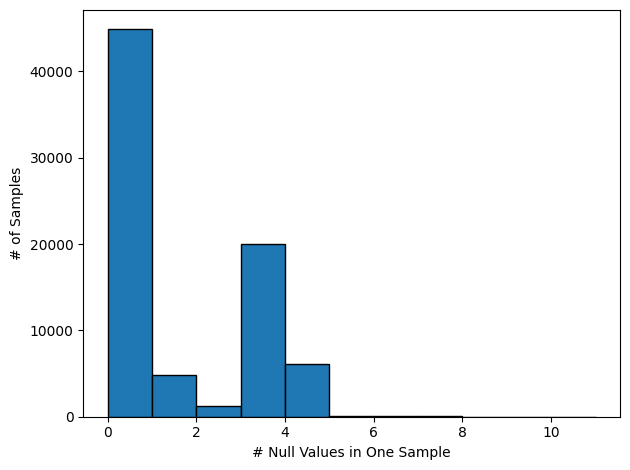

In [498]:
# Dropping samples with null values in the target column. These samples have `parcelid` values but no other feature or target data.
target_nulls_df = df_trim.drop(index = df_trim[df_trim['taxvaluedollarcnt'].isnull()].index)
target_nulls_df.info()
print(f"{len(df_trim[df_trim['taxvaluedollarcnt'].isnull()])} samples were dropped.")

# Plotting a histogram to see the number of samples with missing values
null_count = target_nulls_df.isnull().sum(axis=1)

plt.hist(null_count, bins = range(null_count.min(), null_count.max() + 2), edgecolor='black')
plt.xlabel('# Null Values in One Sample')
plt.ylabel('# of Samples')
plt.tight_layout()
plt.show()

In [499]:
# Removing the samples with some number of null values (based on the histogram above)

bias_threshold = 5
less_nulls_df = target_nulls_df.drop(index = target_nulls_df[target_nulls_df.isnull().sum(axis = 1) >= bias_threshold].index)
less_nulls_df.info()
print(f"{len(target_nulls_df[target_nulls_df.isnull().sum(axis=1) >= bias_threshold])} samples were dropped.")

<class 'pandas.core.frame.DataFrame'>
Index: 77064 entries, 0 to 77612
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77064 non-null  float64
 1   buildingqualitytypeid         49669 non-null  float64
 2   calculatedbathnbr             76645 non-null  float64
 3   calculatedfinishedsquarefeet  77060 non-null  float64
 4   garagecarcnt                  77064 non-null  float64
 5   garagetotalsqft               77064 non-null  float64
 6   hashottuborspa                77064 non-null  int64  
 7   heatingorsystemtypeid         49439 non-null  float64
 8   lotsizesquarefeet             69018 non-null  float64
 9   poolcnt                       77064 non-null  float64
 10  propertycountylandusecode     77064 non-null  object 
 11  propertylandusetypeid         77064 non-null  float64
 12  regionidcity                  75670 non-null  float64
 13  region

In [500]:
## Dropping `regionidcity` because of non-imputable missing values

less_nulls_df = less_nulls_df.drop(columns = 'regionidcity', axis=1)
less_nulls_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 77064 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77064 non-null  float64
 1   buildingqualitytypeid         49669 non-null  float64
 2   calculatedbathnbr             76645 non-null  float64
 3   calculatedfinishedsquarefeet  77060 non-null  float64
 4   garagecarcnt                  77064 non-null  float64
 5   garagetotalsqft               77064 non-null  float64
 6   hashottuborspa                77064 non-null  int64  
 7   heatingorsystemtypeid         49439 non-null  float64
 8   lotsizesquarefeet             69018 non-null  float64
 9   poolcnt                       77064 non-null  float64
 10  propertycountylandusecode     77064 non-null  object 
 11  propertylandusetypeid         77064 non-null  float64
 12  regionidcounty                77064 non-null  float64
 13  region

#### <font color='limegreen'> Outliers </font>

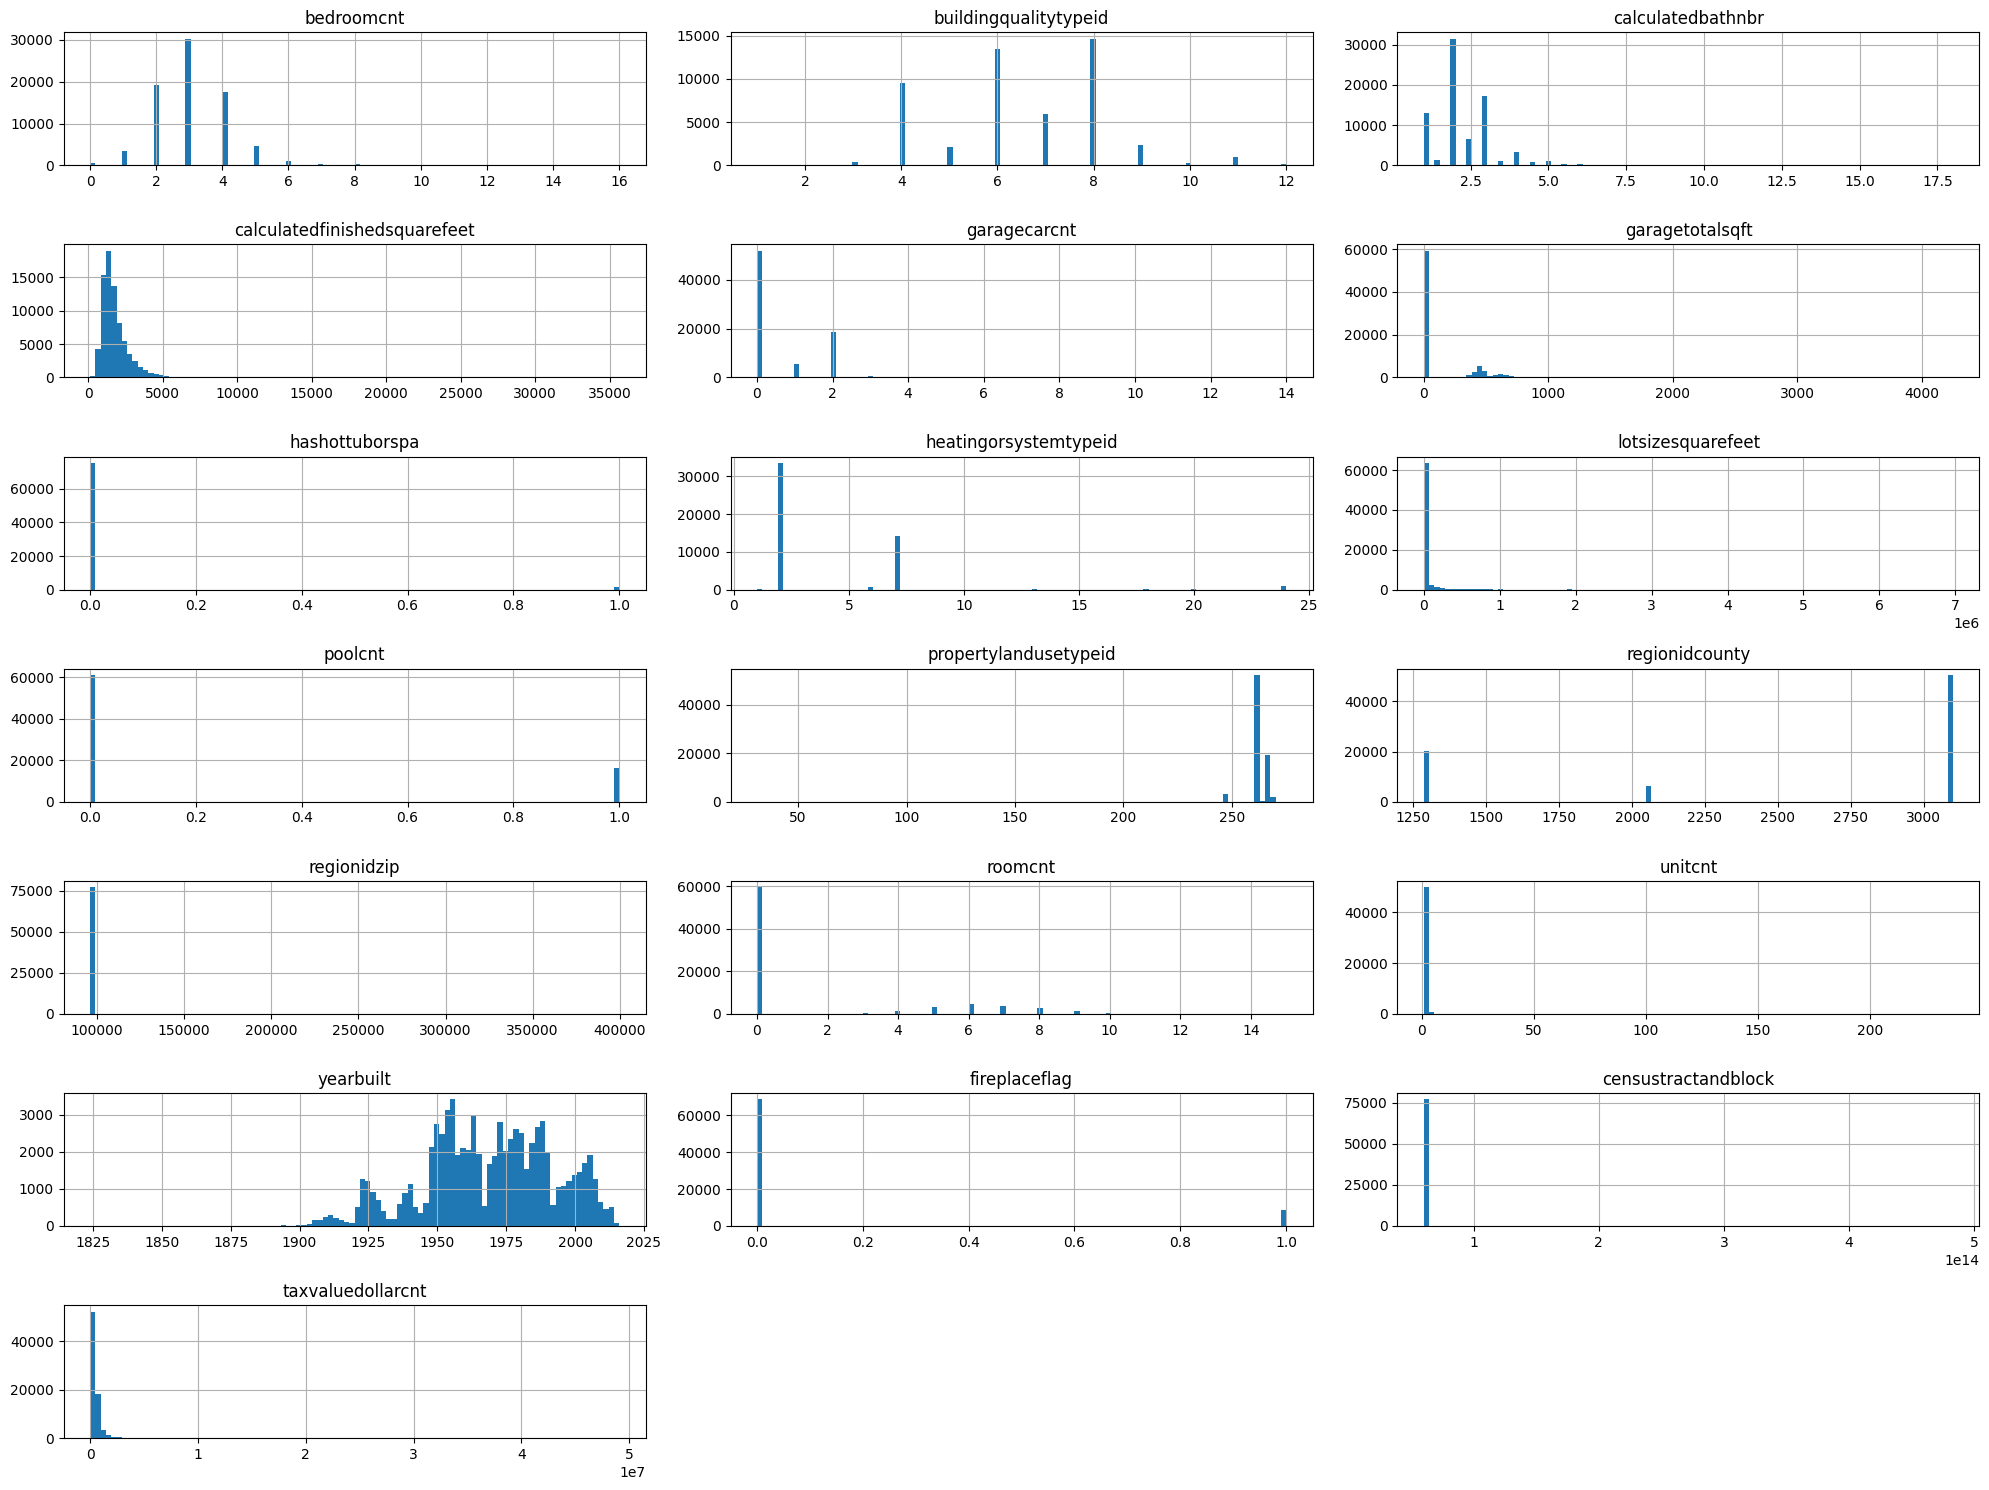

In [501]:
# Just a quick glance a the histograms for each feature to identify possible outliers

less_nulls_df.hist(bins=100, layout=(-1, 3), figsize=(20, 15))
plt.tight_layout()
plt.show()

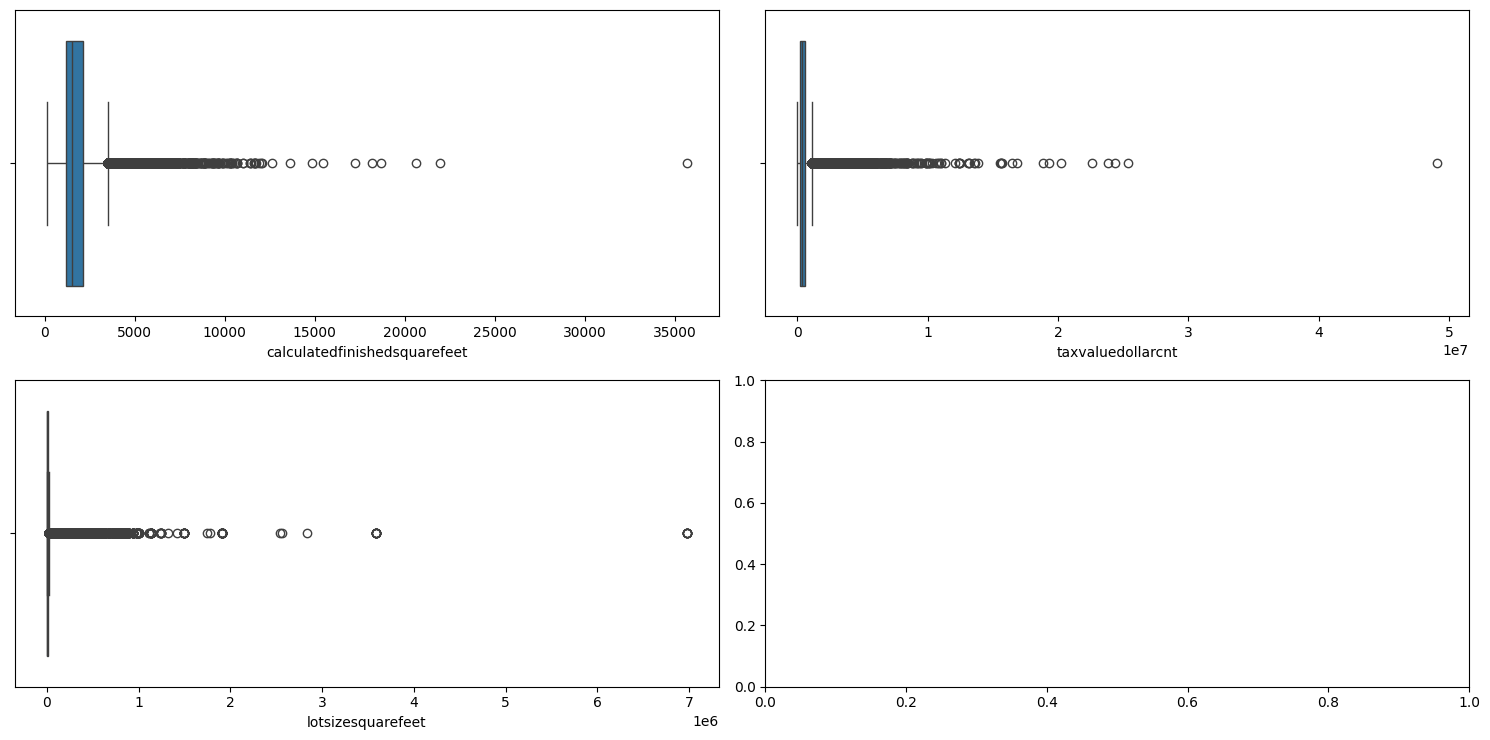

In [502]:
# Plotting boxplots to find outliers

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7.5))
sns.boxplot(x = less_nulls_df['calculatedfinishedsquarefeet'], ax = ax[0, 0])
sns.boxplot(x = less_nulls_df['taxvaluedollarcnt'], ax = ax[0, 1])
sns.boxplot(x = less_nulls_df['lotsizesquarefeet'], ax=ax[1, 0])
plt.tight_layout()
plt.show()

In [503]:
# Finding the index of the samples with outlier values
# Note: will need to perform boxplots on the features to find/see the outliers

max_index_calc = less_nulls_df['calculatedfinishedsquarefeet'].idxmax()
max_index_tax = less_nulls_df['taxvaluedollarcnt'].idxmax()
# max_index_finished = less_nulls['finishedsquarefeet50'].idxmax()
max_index_lot = less_nulls_df['lotsizesquarefeet'].idxmax()

outliers = [max_index_calc, max_index_tax, max_index_lot]
print(outliers)
# print(max_index_calc, max_index_tax, max_index_finished, max_index_lot)

[np.int64(37742), np.int64(8556), np.int64(4215)]


In [504]:
# Dropping the outliers based on the indices

pre_impute_df = less_nulls_df.drop(outliers, axis=0)
pre_impute_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77061 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77061 non-null  float64
 1   buildingqualitytypeid         49666 non-null  float64
 2   calculatedbathnbr             76643 non-null  float64
 3   calculatedfinishedsquarefeet  77057 non-null  float64
 4   garagecarcnt                  77061 non-null  float64
 5   garagetotalsqft               77061 non-null  float64
 6   hashottuborspa                77061 non-null  int64  
 7   heatingorsystemtypeid         49438 non-null  float64
 8   lotsizesquarefeet             69016 non-null  float64
 9   poolcnt                       77061 non-null  float64
 10  propertycountylandusecode     77061 non-null  object 
 11  propertylandusetypeid         77061 non-null  float64
 12  regionidcounty                77061 non-null  float64
 13  region

#### <font color='limegreen'> **3.C Discussion** </font>
In a short paragraph, explain your decision about which samples were dropped


<font color='magenta'> We initially dropped all samples that have a missing value in the target column. This was done since we did not want to impute any values into the target column to avoid any bias. We thought that it would be better to have less entries than have a biased model. In any case, we only dropped 34 samples. <br><br>
 We additionally dropped 316 samples that contained null values in 5 or more features. This was determined via a histogram that graphed the frequency of samples with an 'x' number of null values. Based on the histogram, there is a clear drop off from 4 null values to 5+ null values, so we decided to cut out all samples beyond this point. <br><br>
 Lastly, a complete histogram was done for all the features again to find features with possible outliers. This led us to looking at 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', and 'taxvaluedollarcnt' more closely with boxplots, which revealed that all of them had a clear extreme outlier. Thus, we decided to take out these 4 samples.</font>

### 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [505]:
pre_impute_df

,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertycountylandusecode,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,censustractandblock,taxvaluedollarcnt
0,4.0,NaN,3.5,3100.0,2.0,633.0,0,NaN,4506.0,0.0,122,261.0,1286.0,96978.0,0.0,NaN,1998.0,0,6.059063e+13,1023282.0
1,2.0,NaN,1.0,1465.0,1.0,0.0,0,NaN,12647.0,0.0,1110,261.0,2061.0,97099.0,5.0,NaN,1967.0,1,6.111001e+13,464000.0
2,3.0,NaN,2.0,1243.0,2.0,440.0,0,NaN,8432.0,1.0,122,261.0,1286.0,97078.0,6.0,NaN,1962.0,0,6.059022e+13,564778.0
3,4.0,8.0,3.0,2376.0,0.0,0.0,0,2.0,13038.0,1.0,0101,261.0,3101.0,96330.0,0.0,1.0,1970.0,0,6.037300e+13,145143.0
4,3.0,8.0,3.0,1312.0,0.0,0.0,0,2.0,278581.0,1.0,010C,266.0,3101.0,96451.0,0.0,1.0,1964.0,0,6.037124e+13,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,8.0,3.0,1741.0,0.0,0.0,0,2.0,59487.0,1.0,010C,266.0,3101.0,96415.0,0.0,1.0,1980.0,0,6.037132e+13,379000.0
77609,2.0,6.0,2.0,1286.0,0.0,0.0,0,2.0,47405.0,0.0,0100,261.0,3101.0,96284.0,0.0,1.0,1940.0,0,6.037101e+13,354621.0
77610,4.0,NaN,2.0,1612.0,2.0,560.0,0,NaN,12105.0,0.0,1111,261.0,2061.0,97116.0,7.0,NaN,1964.0,1,6.111008e+13,67205.0
77611,3.0,4.0,1.0,1032.0,0.0,0.0,0,2.0,5074.0,0.0,0100,261.0,3101.0,96480.0,0.0,1.0,1954.0,0,6.037434e+13,49546.0


In [506]:
show_null_counts_features(pre_impute_df)

The dataset contains 77061 samples.



,Feature,#_Null_Values,Null_%,Feature_Dtype
3,heatingorsystemtypeid,27623,35.85,float64
0,buildingqualitytypeid,27395,35.55,float64
6,unitcnt,26507,34.40,float64
4,lotsizesquarefeet,8045,10.44,float64
1,calculatedbathnbr,418,0.54,float64
8,censustractandblock,159,0.21,float64
7,yearbuilt,68,0.09,float64
5,regionidzip,28,0.04,float64
2,calculatedfinishedsquarefeet,4,0.01,float64


In [507]:
impute_strategies = ['median', 'most_frequent']
impute_cols_1 = ['unitcnt', 'heatingorsystemtypeid', 'buildingqualitytypeid', 'calculatedbathnbr','yearbuilt', 'regionidzip']

imputer = SimpleImputer(strategy = impute_strategies[1])

pre_impute_df[impute_cols_1] = imputer.fit_transform(pre_impute_df[impute_cols_1])

imputed_df = pre_impute_df.copy()
imputed_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 77061 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77061 non-null  float64
 1   buildingqualitytypeid         77061 non-null  float64
 2   calculatedbathnbr             77061 non-null  float64
 3   calculatedfinishedsquarefeet  77057 non-null  float64
 4   garagecarcnt                  77061 non-null  float64
 5   garagetotalsqft               77061 non-null  float64
 6   hashottuborspa                77061 non-null  int64  
 7   heatingorsystemtypeid         77061 non-null  float64
 8   lotsizesquarefeet             69016 non-null  float64
 9   poolcnt                       77061 non-null  float64
 10  propertycountylandusecode     77061 non-null  object 
 11  propertylandusetypeid         77061 non-null  float64
 12  regionidcounty                77061 non-null  float64
 13  region

In [508]:
imputed_df = imputed_df.dropna(subset='censustractandblock')
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76902 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    76902 non-null  float64
 1   buildingqualitytypeid         76902 non-null  float64
 2   calculatedbathnbr             76902 non-null  float64
 3   calculatedfinishedsquarefeet  76898 non-null  float64
 4   garagecarcnt                  76902 non-null  float64
 5   garagetotalsqft               76902 non-null  float64
 6   hashottuborspa                76902 non-null  int64  
 7   heatingorsystemtypeid         76902 non-null  float64
 8   lotsizesquarefeet             68961 non-null  float64
 9   poolcnt                       76902 non-null  float64
 10  propertycountylandusecode     76902 non-null  object 
 11  propertylandusetypeid         76902 non-null  float64
 12  regionidcounty                76902 non-null  float64
 13  region

In [509]:
### IMPUTE median for remaining features.

impute_cols_2 = ['lotsizesquarefeet', 'calculatedfinishedsquarefeet']
imputer = SimpleImputer(strategy = impute_strategies[0])

imputed_df[impute_cols_2] = imputer.fit_transform(imputed_df[impute_cols_2])

In [510]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76902 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    76902 non-null  float64
 1   buildingqualitytypeid         76902 non-null  float64
 2   calculatedbathnbr             76902 non-null  float64
 3   calculatedfinishedsquarefeet  76902 non-null  float64
 4   garagecarcnt                  76902 non-null  float64
 5   garagetotalsqft               76902 non-null  float64
 6   hashottuborspa                76902 non-null  int64  
 7   heatingorsystemtypeid         76902 non-null  float64
 8   lotsizesquarefeet             76902 non-null  float64
 9   poolcnt                       76902 non-null  float64
 10  propertycountylandusecode     76902 non-null  object 
 11  propertylandusetypeid         76902 non-null  float64
 12  regionidcounty                76902 non-null  float64
 13  region

##### **3.D Discussion**  
Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


<font color='magenta'> We imputed using the mode for ['unitcnt', 'heatingorsystemtypeid', 'buildingqualitytypeid', 'calculatedbathnbr','yearbuilt', 'regionidzip'] and using the median for the remaining features.

### <font color='limegreen'>3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

<font color='magenta'>We need to encode `propertycountylandusecode`. See:
https://dts.edatatrace.com/dts3/content/doc/whelp/mergedProjects/dts2tt/mergedProjects/dts2ttcs/land_use_la.htm



In [511]:
# Initialize OrdinalEncoder to encode `propertycountylandusecode`
encoder = OrdinalEncoder()
imputed_df['propertycountylandusecode'] = encoder.fit_transform(imputed_df[['propertycountylandusecode']])
imputed_df

,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertycountylandusecode,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,censustractandblock,taxvaluedollarcnt
0,4.0,8.0,3.5,3100.0,2.0,633.0,0,2.0,4506.0,0.0,57.0,261.0,1286.0,96978.0,0.0,1.0,1998.0,0,6.059063e+13,1023282.0
1,2.0,8.0,1.0,1465.0,1.0,0.0,0,2.0,12647.0,0.0,48.0,261.0,2061.0,97099.0,5.0,1.0,1967.0,1,6.111001e+13,464000.0
2,3.0,8.0,2.0,1243.0,2.0,440.0,0,2.0,8432.0,1.0,57.0,261.0,1286.0,97078.0,6.0,1.0,1962.0,0,6.059022e+13,564778.0
3,4.0,8.0,3.0,2376.0,0.0,0.0,0,2.0,13038.0,1.0,1.0,261.0,3101.0,96330.0,0.0,1.0,1970.0,0,6.037300e+13,145143.0
4,3.0,8.0,3.0,1312.0,0.0,0.0,0,2.0,278581.0,1.0,8.0,266.0,3101.0,96451.0,0.0,1.0,1964.0,0,6.037124e+13,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,8.0,3.0,1741.0,0.0,0.0,0,2.0,59487.0,1.0,8.0,266.0,3101.0,96415.0,0.0,1.0,1980.0,0,6.037132e+13,379000.0
77609,2.0,6.0,2.0,1286.0,0.0,0.0,0,2.0,47405.0,0.0,0.0,261.0,3101.0,96284.0,0.0,1.0,1940.0,0,6.037101e+13,354621.0
77610,4.0,8.0,2.0,1612.0,2.0,560.0,0,2.0,12105.0,0.0,49.0,261.0,2061.0,97116.0,7.0,1.0,1964.0,1,6.111008e+13,67205.0
77611,3.0,4.0,1.0,1032.0,0.0,0.0,0,2.0,5074.0,0.0,0.0,261.0,3101.0,96480.0,0.0,1.0,1954.0,0,6.037434e+13,49546.0


In [512]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76902 entries, 0 to 77612
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    76902 non-null  float64
 1   buildingqualitytypeid         76902 non-null  float64
 2   calculatedbathnbr             76902 non-null  float64
 3   calculatedfinishedsquarefeet  76902 non-null  float64
 4   garagecarcnt                  76902 non-null  float64
 5   garagetotalsqft               76902 non-null  float64
 6   hashottuborspa                76902 non-null  int64  
 7   heatingorsystemtypeid         76902 non-null  float64
 8   lotsizesquarefeet             76902 non-null  float64
 9   poolcnt                       76902 non-null  float64
 10  propertycountylandusecode     76902 non-null  float64
 11  propertylandusetypeid         76902 non-null  float64
 12  regionidcounty                76902 non-null  float64
 13  region

### Splitting/Training Data

In [513]:
df_clean = imputed_df.copy()

In [514]:
df_clean_categorical = df_clean.select_dtypes(include=['object'])
df_clean_numeric = df_clean.select_dtypes(exclude=['object'])

X = df_clean.drop('taxvaluedollarcnt', axis=1)
y = df_clean['taxvaluedollarcnt']

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.



### 4.A

   - Compute and analyze pairwise correlations using a **correlation matrix**.
   - Compute the **F-statistic** for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that   may impact model performance.
   - Investigate *forward* and *backward* **feature selection**
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

  Your code below, in multiple cells with descriptive comments.

##### 4.A.1. Heatmap of Feature Correlation Matrix

In [515]:
imputed_df.corr()

,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertycountylandusecode,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,censustractandblock,taxvaluedollarcnt
bedroomcnt,1.000000,0.088043,0.609675,0.636801,0.141400,0.257269,0.120543,-0.149926,-0.093800,0.097752,0.026352,-0.292687,-0.017900,0.016496,0.166017,0.083961,0.048395,0.116856,0.008287,0.246801
buildingqualitytypeid,0.088043,1.000000,0.413619,0.326064,0.397152,0.316168,0.086855,-0.361774,0.042427,0.172040,0.418551,0.286469,-0.429628,0.045098,0.319704,-0.074693,0.561157,0.214020,0.043803,0.260349
calculatedbathnbr,0.609675,0.413619,1.000000,0.798777,0.141912,0.194412,0.168322,-0.272448,0.005752,0.216097,0.071080,-0.092098,-0.038435,0.020788,0.031679,0.076217,0.373268,0.059198,0.002717,0.483092
calculatedfinishedsquarefeet,0.636801,0.326064,0.798777,1.000000,0.191796,0.301940,0.225697,-0.213314,-0.044807,0.240183,0.062228,-0.215117,-0.069496,0.024700,0.099270,0.080000,0.220882,0.103719,0.006929,0.592282
garagecarcnt,0.141400,0.397152,0.141912,0.191796,1.000000,0.844350,0.257570,-0.148425,-0.104323,-0.013170,0.834000,0.048056,-0.862881,0.061776,0.708498,-0.048670,0.306491,0.515303,0.094077,0.095475
garagetotalsqft,0.257269,0.316168,0.194412,0.301940,0.844350,1.000000,0.317182,-0.189941,-0.078848,0.074231,0.632108,-0.088237,-0.687699,0.048678,0.710466,-0.039302,0.194457,0.501123,0.074591,0.140147
hashottuborspa,0.120543,0.086855,0.168322,0.225697,0.257570,0.317182,1.000000,-0.049142,-0.020105,0.171582,0.181477,-0.022362,-0.223055,0.014868,0.076015,-0.010558,0.117885,0.042281,0.008724,0.148431
heatingorsystemtypeid,-0.149926,-0.361774,-0.272448,-0.213314,-0.148425,-0.189941,-0.049142,1.000000,-0.057581,-0.127077,-0.073381,-0.012858,0.063158,-0.018225,-0.032473,-0.008313,-0.291819,-0.112871,-0.018514,-0.106520
lotsizesquarefeet,-0.093800,0.042427,0.005752,-0.044807,-0.104323,-0.078848,-0.020105,-0.057581,1.000000,0.118314,-0.087827,0.132584,0.120752,-0.005091,-0.083360,-0.013315,0.091757,-0.053885,-0.012750,-0.021082
poolcnt,0.097752,0.172040,0.216097,0.240183,-0.013170,0.074231,0.171582,-0.127077,0.118314,1.000000,-0.079459,0.080178,0.068313,0.005349,0.029614,-0.037324,0.076870,0.030093,-0.011242,0.173240


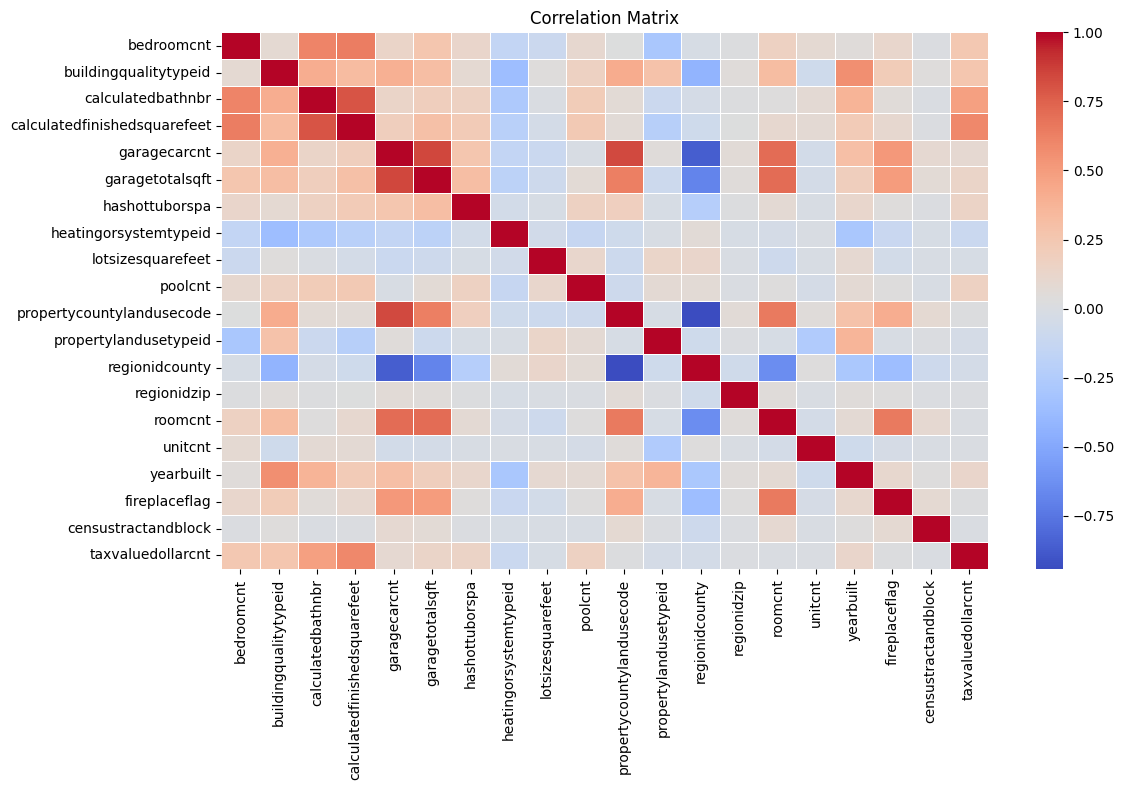

In [521]:

plt.figure(figsize=(12, 8))
sns.heatmap(imputed_df.corr(), cmap='coolwarm', annot=False, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

##### 4.A.2. F-statistics

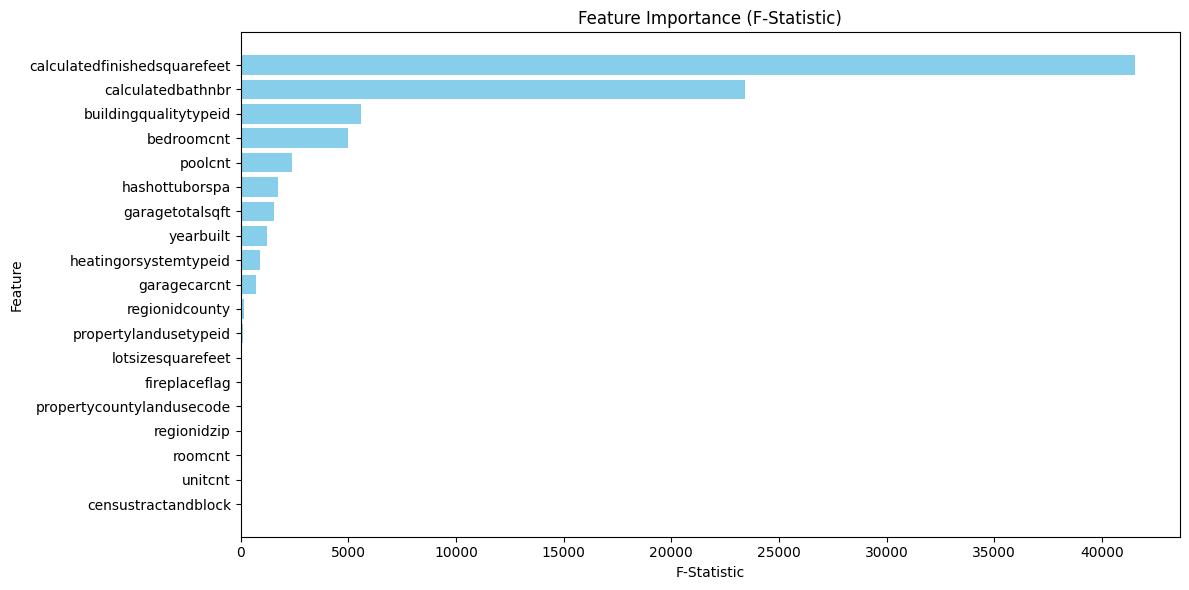

In [523]:
scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X)
y_scaled  = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Compute F-statistics and p-values
F_scores, p_values = f_regression(X_scaled, y_scaled)

# Create a DataFrame for visualization
f_df = pd.DataFrame({'Feature': X.columns, 'F-Statistic': F_scores})
f_df = f_df.sort_values(by='F-Statistic', ascending=False)  # Sort by importance

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(f_df['Feature'], f_df['F-Statistic'], color='skyblue')
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.title('Feature Importance (F-Statistic)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

##### 4.A.3 Feature Selection

In [533]:
from sklearn.linear_model import LinearRegression


# selected_features_fwd, best_scores_fwd, best_feature_set_fwd, best_score_fwd = forward_feature_selection(X_scaled, y_scaled, LinearRegression())
# print("Best Scores:", best_scores_fwd)
# print("Best Feature Set:", best_feature_set_fwd)
# print("Best Score:", best_score_fwd)


sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=10, direction='forward')
sfs.fit(X_scaled, y_scaled)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10)

In [534]:
# Get the selected feature indices
selected_feature_indices = sfs.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

print("Selected Feature Indices:", selected_feature_indices)
print("Selected Feature Names:", selected_feature_names)

Selected Feature Indices: [ 0  1  2  3  4  7 10 11 14 16]
Selected Feature Names: Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'garagecarcnt', 'heatingorsystemtypeid',
       'propertycountylandusecode', 'propertylandusetypeid', 'roomcnt',
       'yearbuilt'],
      dtype='object')


#### **4.A Discussion**  
Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



<font color='magenta'> TBD

### 4.B.  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

#### Pair plots

In [536]:
# Pairplots based on feature selection above

plt.figure(figsize=(12, 12))

features = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr','calculatedfinishedsquarefeet','finishedsquarefeet12']

selected_features_df = X_scaled[selected_feature_indices]
selected_features_df = pd.DataFrame(selected_features_df, columns=selected_feature_names)
selected_features_df['taxvaluedollarcnt'] = y_scaled

sns.pairplot(selected_features_df)
plt.suptitel('Pairplot for Selected Features', y = 1.01)
plt.tight_layout()
plt.show()

ValueError: Shape of passed values is (10, 19), indices imply (10, 10)

<Figure size 1200x1200 with 0 Axes>

In [ ]:
# Three scatterplots of features vs target

#### **4.B Discussion**
Provide brief interpretations of any observed patterns or trends.


<font color='magenta'> INSERT ANALYSIS </font>

## Part 5:  Feature Engineering
Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]



**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.

- Understand that you can't evaluate the final usefulness of these transformations until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).

- Therefore, write your transformations as functions or otherwise be prepared to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary

- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).

- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

### 5a. Transformations

### **5b. Discussion**
Describe in a paragraph why you chose these transformations and what you observed.


<font color = 'magenta'> INSERT ANALYSIS

## **Appendix 1: Features of the Zillow Dataset**  



0. **~~parcelid~~**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. ~~**architecturalstyletypeid**:~~ Identifier for the architectural style of the property.  
3. ~~**basementsqft**:~~ Square footage of the basement.  
4. **~~bathroomcnt~~**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. ~~**buildingqualitytypeid**:~~ Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **~~finishedfloor1squarefeet~~**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **~~finishedsquarefeet13~~**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **~~finishedsquarefeet6~~**: Base unfinished and finished area square footage.  
17. **~~fips~~**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **~~fullbathcnt~~**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **~~latitude~~**: Latitude coordinate of the property.  
25. **~~longitude~~**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **~~pooltypeid10~~**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **~~rawcensustractandblock~~**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **~~storytypeid~~**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **~~threequarterbathnbr~~**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **~~assessmentyear~~**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **~~taxdelinquencyyear~~**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## **Appendix 2: Summary of Basic Imputation Methods**
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |



# <font color = 'red'>Proposed Merges

##### Dropping problematic samples

In [ ]:
# Dropping samples with null values in the target column

target_nulls = no_nulls.drop(index = no_nulls[no_nulls['taxvaluedollarcnt'].isnull()].index)
target_nulls.info()
print(f"{len(no_nulls[no_nulls['taxvaluedollarcnt'].isnull()])} samples were dropped.")

In [ ]:
# Plotting a histogram to see the number of samples with missing values

null_count = target_nulls.isnull().sum(axis=1)

plt.hist(null_count, bins = range(null_count.min(), null_count.max() + 2), edgecolor='black')
plt.xlabel('# Null Values in One Sample')
plt.ylabel('# of Samples')
plt.show()

In [ ]:
# Removing the samples with some number of null values (will be based on the histogram above)

less_nulls = target_nulls.drop(index=target_nulls[target_nulls.isnull().sum(axis=1) >= 5].index)
less_nulls.info()
print(f"{len(target_nulls[target_nulls.isnull().sum(axis=1) >= 5])} samples were dropped.")

##### Dropping possible outliers

In [ ]:
# Finding the index of the samples with outlier values
# Note: will need to perform boxplots on the features to find/see the outliers

max_index_calc = df_imputed_again['calculatedfinishedsquarefeet'].idxmax()
max_index_tax = df_imputed_again['taxvaluedollarcnt'].idxmax()

print(max_index_calc, max_index_tax)

In [ ]:
# Dropping the outliers based on the indices

df_clean = df_imputed_again.drop([37742, 8556], axis=0)
df_clean.info()